In [1]:
# Import the moduli
import numpy as np
import pandas as pd
import shap
import os
import sys
import pickle
import xgboost as xgb
import seaborn as sns

sys.path.append("../../")
from utils import *

In [2]:
# Load the data
year = 2018
periodo = 2

# Training data directory
data_for_training = "../../../data/Data_For_Training/"

# Read data_training
df_training = pd.read_csv(data_for_training + "icfes_{0}{1}.csv".format(year, periodo))

# lista de las columnas con las caracteristicas a predecir
notasz = [c for c in df_training.columns.values if c.startswith("NOTA_Z")]
deciles = [c for c in df_training.columns.values if c.startswith("DECILE")]
labels_names = notasz + deciles

# lista de las columnas que se van a omitir de las caracteristicas
vars_2_omit = (
    [
        "PUNT_LECTURA_CRITICA",
        "PERCENTIL_LECTURA_CRITICA",
        "DESEMP_LECTURA_CRITICA",
        "PUNT_MATEMATICAS",
        "PERCENTIL_MATEMATICAS",
        "DESEMP_MATEMATICAS",
        "PUNT_C_NATURALES",
        "PERCENTIL_C_NATURALES",
        "DESEMP_C_NATURALES",
        "PUNT_SOCIALES_CIUDADANAS",
        "PERCENTIL_SOCIALES_CIUDADANAS",
        "DESEMP_SOCIALES_CIUDADANAS",
        "PUNT_INGLES",
        "PERCENTIL_INGLES",
        "DESEMP_INGLES",
        "PUNT_GLOBAL",
        "PERCENTIL_GLOBAL",
    ]
    + deciles
    + notasz
)

labels = df_training[labels_names]
features = df_training.drop(vars_2_omit, axis=1)
mask_nota_z = [
    False
    if "COLE" in col or "DEPTO" in col or "MCPIO" in col or "ESTABLECIMIENTO" in col
    else True
    for col in features.columns
]

# Cargar los escalador de las caracteristicas
scaler_features = pickle.load(open("../models/scaler_features_20182.pkl", "rb"))
print(deciles)

['DECILE_PUNT_MATEMATICAS', 'DECILE_PUNT_LECTURA_CRITICA', 'DECILE_PUNT_C_NATURALES', 'DECILE_PUNT_SOCIALES_CIUDADANAS', 'DECILE_PUNT_INGLES', 'DECILE_PUNT_GLOBAL']


Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


# Descripción de las estadísticas descriptivas

## Estadística descripción para la interacción NSE_INDIVIDUAL y NSE_ESTABLECIMIENTO

En la encuesta socioeconómica del perido **2018-2** se agrega una variable que estaba ausente en los demás periodos, el **Nivel Socio Económico del Colegio** notado como ESTU_NSE_ESTABLECIMIENTO. Las interacciones de las variables Nivel Socio Económico Individual (ESTU_NSE_INDIVIDUAL) y Nivel Socio Económico del Colegio (ESTU_NSE_ESTABLECIMIENTO) generan un agrupamiento de los datos tal que el **estrato** de la vivienda tiene un impacto inverso al esperado al predecir el desempeño de los estudiantes. Ya que el estrato de la vivienda esta relacionado con la capacidad adquisitiva de la familia del estudiante, entonces se espera que a ha mayor estrato el estudiante tenga un mayor puntaje y es de hecho lo que se observa si solamente se grafica el puntaje en función del estrato, mas si anteriormente se hace un filtrado por NSE_INDIVIDUAL y NSE_ESTABLECIMIENTO entonces a menor estrato mayor puntaje promedio.

Este efecto vemos que se puede interpretar como un caso de la [paradoja de Simpson](https://en.wikipedia.org/wiki/Simpson%27s_paradox)

In [56]:
!jupyter nbconvert --to html boxplots_NSE_and_estrato.ipynb

[NbConvertApp] Converting notebook boxplots_NSE_and_estrato.ipynb to html
[NbConvertApp] Writing 3370135 bytes to boxplots_NSE_and_estrato.html


### Puntaje según NSE y según estrato de la vivienda

Se observa que al agrupar únicamente por el estrato de la vivienda, el NSE_INDIVIDUAL o el NSE_ESTABLECIMIENTO hay una relación directa entre puntaje promedio y mayor estrato de la vivienda (NSE_INDIVIDUAL y NSE_ESTABLECIMIENTO respectivamente).

In [4]:
from bioinfokit.analys import stat

def tukey_undistinguishable(df, category, value, groupby=None):
    print("Comparing groups of category", category)
    if groupby is not None:
        for name, group in df.groupby(groupby):
            res = stat()
            try:
                res.tukey_hsd(df=group, res_var=value, xfac_var=category, anova_model=f'{value} ~ C({category})')
            except ValueError as e:
                print(name)
                print(group)
                raise e
            df_result = res.tukey_summary
            df_result = df_result[df_result["p-value"] > 0.001]
            if df_result.empty:
                print(f"All differences for {groupby}=={name} were significant")
            else:
                print(f"Filter: {groupby}=={name}")
                print(df_result)
    else:
        res = stat()
        res.tukey_hsd(df=df, res_var=value, xfac_var=category, anova_model=f'{value} ~ C({category})')
        df_result = res.tukey_summary
        df_result = df_result[df_result["p-value"] > 0.001]
        if df_result.empty:
            print("All differences were significant")
        else:
            print(df_result)
    print("*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*")


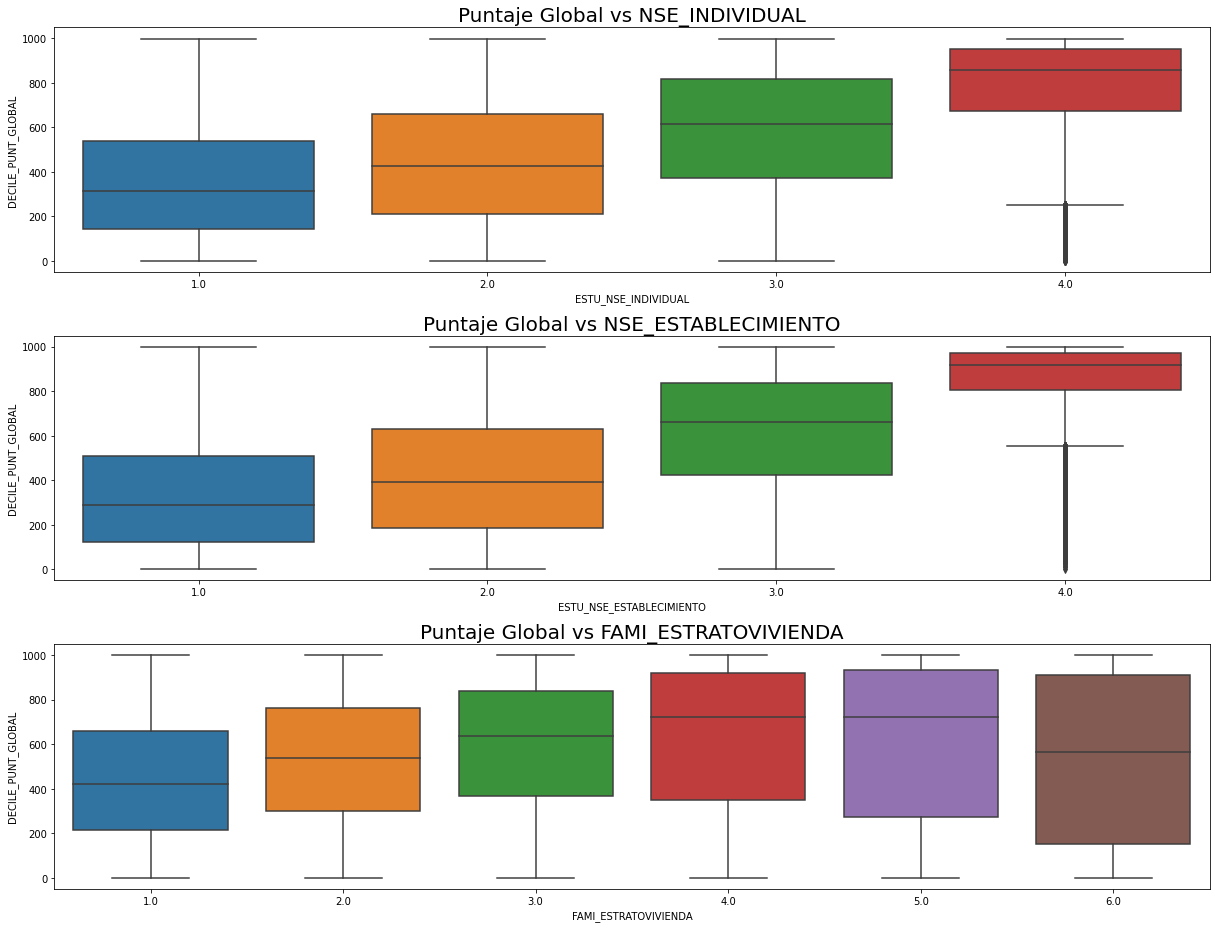

In [5]:
fig, ax = plt.subplots(nrows=3)
ax_1 , ax_2, ax_3 = ax
fig.set_size_inches(17, 13)
sns.boxplot(x="ESTU_NSE_INDIVIDUAL",y="DECILE_PUNT_GLOBAL",data=df_training,ax=ax_1).set_title("Puntaje Global vs NSE_INDIVIDUAL",fontsize=20)
sns.boxplot(x="ESTU_NSE_ESTABLECIMIENTO",y="DECILE_PUNT_GLOBAL",data=df_training,ax=ax_2).set_title("Puntaje Global vs NSE_ESTABLECIMIENTO",fontsize=20)
sns.boxplot(x="FAMI_ESTRATOVIVIENDA",y="DECILE_PUNT_GLOBAL",data=df_training,ax=ax_3).set_title("Puntaje Global vs FAMI_ESTRATOVIVIENDA",fontsize=20)
#ax_3.set_yscale('log')
plt.tight_layout()

In [6]:
tukey_undistinguishable(df_training, 'ESTU_NSE_INDIVIDUAL', 'DECILE_PUNT_GLOBAL')
tukey_undistinguishable(df_training, 'ESTU_NSE_ESTABLECIMIENTO', 'DECILE_PUNT_GLOBAL')
tukey_undistinguishable(df_training, 'FAMI_ESTRATOVIVIENDA', 'DECILE_PUNT_GLOBAL')

Comparing groups of category ESTU_NSE_INDIVIDUAL
All differences were significant
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Comparing groups of category ESTU_NSE_ESTABLECIMIENTO
All differences were significant
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Comparing groups of category FAMI_ESTRATOVIVIENDA
    group1  group2      Diff      Lower      Upper   q-value   p-value
9      3.0     6.0  8.146485 -10.073428  26.366398  1.801924  0.773066
14     4.0     5.0  4.983531  -8.724896  18.691959  1.465082  0.900000
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


## NSE_INDIVIDUAL y NSE_ESTABLECIMIENTO

El NSE individual se obtiene del INSE_INDIVIDUAL (índice socio económico individual) al dividirlo en cuartiles, y el NSE_ESTABLECIMIENTO no sabemos cómo se calcula pero tiene una realación directa con el NSE_INDIVIDUAL i.e. a mayor NSE_INDIVIDUAL mayor es el NSE_ESTABLECIMIENTO promedio y viceversa.

**NOTA**: de aquí en adelante las gráficas de histogramas tendrán el eje de cuentas con escala logaritmica, por lo tanto una diferencia que se vea pequeña entre dos barras de histogramas en realidad es bastante grande e.g. aquí usamos logaritmos en base 10 entonces si la altura de dos barras se diferencia por dos marcas granes entonces una de ellas tiene 10 veces más elemntos que la otra.

# PRUEBAS ESTADÍSTICAS

A continuación se muestran pruebas estadísticas que comparan grupos de distinas índoles. Las gráficas a continuación tienen dos agrupaciones. Una agrupación separa grupos de boxplots, y otra agrupación separa distintos boxplots con colores. Pueden haber dos comparaciones entre grupos

1. Fijar un color y comparar grupos de distintos boxplots.
2. Fijar un grupo de boxplots y comparar entre grupos de distinto color.

Estas pruebas se realizan sobre todos los boxplots **excepto** los últimos (más adelante en el boxplot) porque son redundantes con algunos tests hechos anteriormente.

Los tests imprimen cuales son los grupos comparados que **no** son significativamente diferentes.

Más adelante daremos la interpretación de unos resultados como ejemplo.

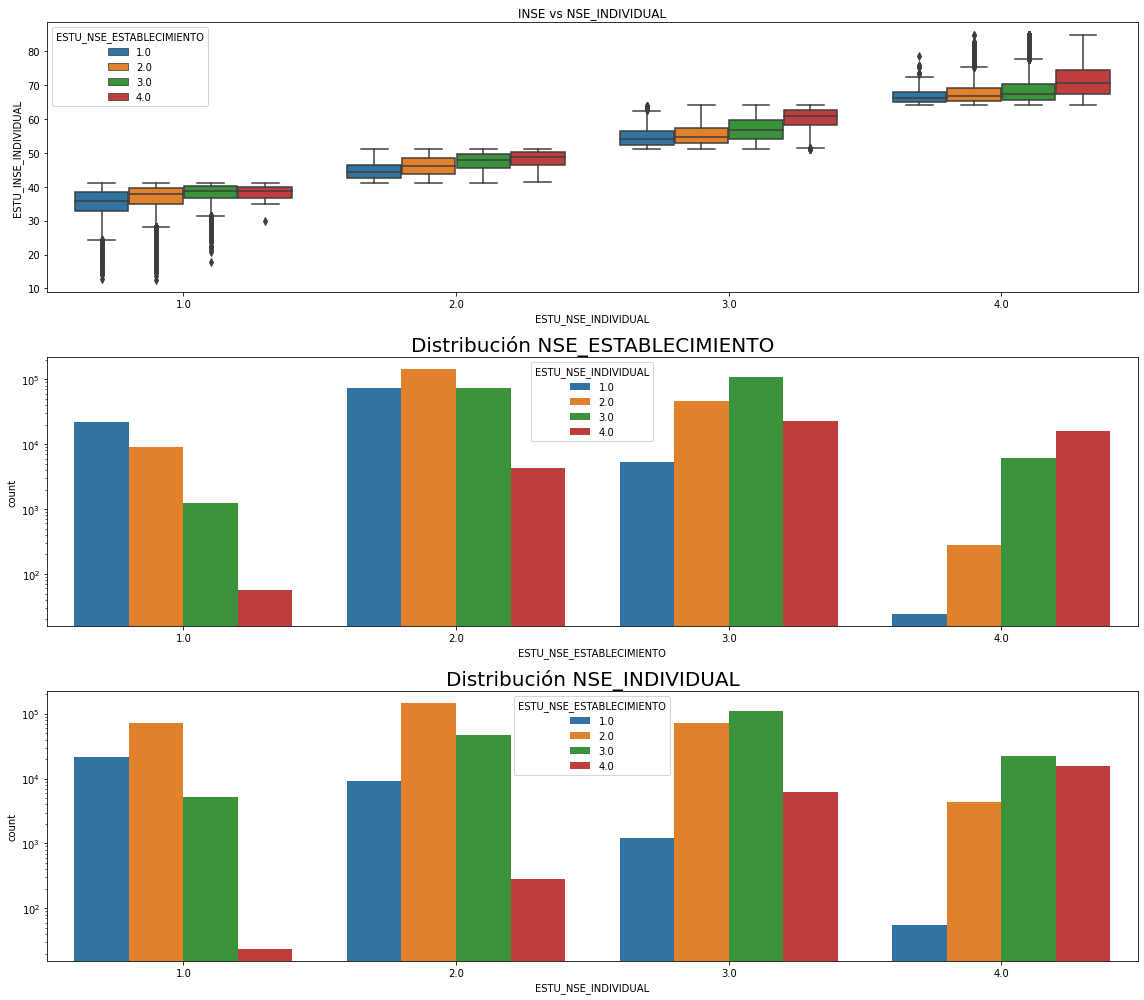

In [7]:
# Estrato según NSE
fig, ax = plt.subplots(nrows=3)
ax_1 , ax_2, ax_3 = ax
fig.set_size_inches(16, 14)
sns.boxplot(x="ESTU_NSE_INDIVIDUAL",y="ESTU_INSE_INDIVIDUAL",hue="ESTU_NSE_ESTABLECIMIENTO",data=df_training,ax=ax_1).set_title("INSE vs NSE_INDIVIDUAL")
sns.countplot(x="ESTU_NSE_ESTABLECIMIENTO",hue="ESTU_NSE_INDIVIDUAL",data=df_training,ax=ax_2).set_title("Distribución NSE_ESTABLECIMIENTO".format(1),fontsize=20)
ax_2.set_yscale('log')
sns.countplot(x="ESTU_NSE_INDIVIDUAL",hue="ESTU_NSE_ESTABLECIMIENTO",data=df_training,ax=ax_3).set_title("Distribución NSE_INDIVIDUAL".format(1),fontsize=20)
ax_3.set_yscale('log')
plt.tight_layout()


In [8]:
tukey_undistinguishable(df_training, 'ESTU_NSE_ESTABLECIMIENTO', 'ESTU_INSE_INDIVIDUAL', groupby='ESTU_NSE_INDIVIDUAL')
tukey_undistinguishable(df_training, 'ESTU_NSE_INDIVIDUAL', 'ESTU_INSE_INDIVIDUAL', groupby='ESTU_NSE_ESTABLECIMIENTO')

Comparing groups of category ESTU_NSE_ESTABLECIMIENTO
Filter: ESTU_NSE_INDIVIDUAL==1.0
   group1  group2      Diff     Lower     Upper   q-value   p-value
2     2.0     4.0  1.562946 -0.813455  3.939347  2.389592  0.329184
4     1.0     4.0  3.202679  0.824100  5.581258  4.892099  0.003046
5     3.0     4.0  0.418182 -1.965080  2.801443  0.637518  0.900000
Filter: ESTU_NSE_INDIVIDUAL==2.0
   group1  group2      Diff     Lower    Upper   q-value  p-value
4     3.0     4.0  0.650834  0.066058  1.23561  4.043617  0.02208
Filter: ESTU_NSE_INDIVIDUAL==3.0
   group1  group2      Diff     Lower     Upper   q-value   p-value
2     2.0     1.0  0.366863 -0.046492  0.780218  3.224551  0.102668
Filter: ESTU_NSE_INDIVIDUAL==4.0
   group1  group2      Diff     Lower     Upper   q-value   p-value
2     2.0     1.0  0.093925 -1.809094  1.996943  0.179327  0.900000
4     3.0     1.0  0.929805 -0.963547  2.823156  1.784307  0.576965
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Comparing groups of 

## Interpretación de pruebas estadísticas

Lo anterior es un reporte de los tests estadísticos de la distribución de **índice de nivel socioeconómico individual**. Lo primero que nos dice el reporte es que se van a comparar grupos de distinto NSE de establecimiento. A continuación se consideran datos solamente para un NSE individual (exactamente el NSE individual 1). En la gráfica lo que esto significa es que se comparan aquellos boxplots de distintos colores correspondientes al primer grupo de NSE individual (los que están a la izquierda). Los siguientes grupos que aparecen nos dicen que no podemos distinguir entre el grupo de NSE establecimiento 2 y el NSE establecimiento 4, ni tampoco podemos distinguir entre el NSE establecimiento 1 y el 4, ni entre el 3 y el 4.

Después, para NSE individual 2 (el segundo bloque de boxplots de distinto color) los tests dicen que no podemos distinguir NSE establecimiento 3 de NSE establecimiento 4. Este análisis se hace para cada grupo de NSE individual.

Después se comparan grupos con distinto NSE_individual, pero se fija el NSE establecimiento (se fija el color). En este caso lo que se observa es que todas las diferencias entre boxplots de igual color son significativas.

## Distribución de puntajes filtrando por NSE y estrato de la vivienda

Al filtrar por cada nivel socioeconómico y graficar la distribución de los puntajes según el estrato dentre de cada pareja (NSE_INDIVIDUAL, NSE_ESTABLECIMIENTO) se observa que a menor estrato mayor puntaje. Esto lo interpretamos como un fenómeno similar al que ocurre con la **Nota z**, donde entre estudiantes de un mismo plantel educativo aquellos con menor cantidad de recursos tienden a tener un mejor desempeño. 

## Puntajes fijando NSE_ESTABLECIMIENTO

Dentro de cada NSE se ve que la tendencia es a menor estrato mayor puntaje

### NSE_ESTABLECIMIENTO = 1

In [9]:
df_nse = df_training[df_training["ESTU_NSE_ESTABLECIMIENTO"]==1.0]

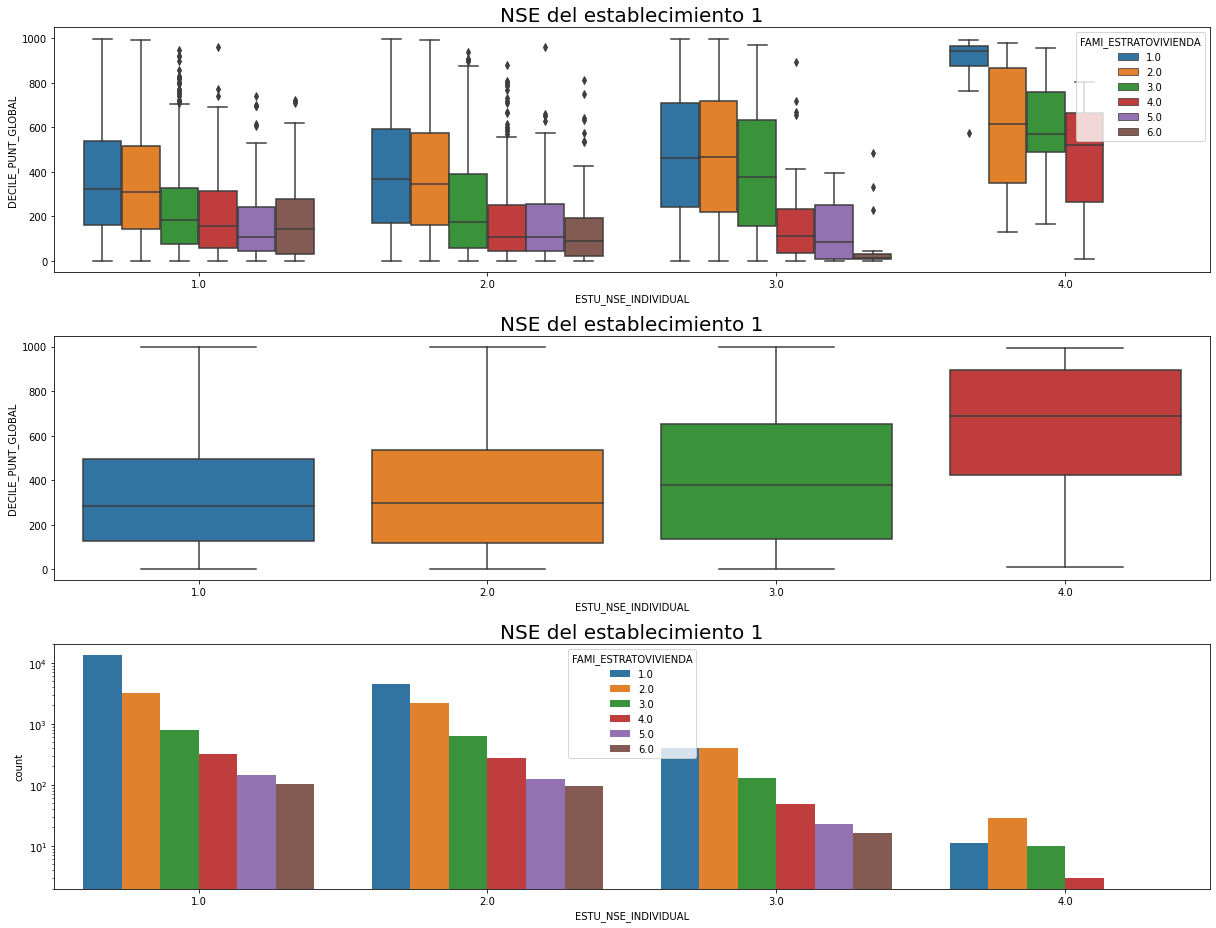

In [10]:
fig, ax = plt.subplots(nrows=3)
ax_1 , ax_2, ax_3 = ax
fig.set_size_inches(17, 13)
sns.boxplot(x="ESTU_NSE_INDIVIDUAL",y="DECILE_PUNT_GLOBAL",hue="FAMI_ESTRATOVIVIENDA",data=df_nse,ax=ax_1).set_title("NSE del establecimiento {}".format(1),fontsize=20)
sns.boxplot(x="ESTU_NSE_INDIVIDUAL",y="DECILE_PUNT_GLOBAL",data=df_nse,ax=ax_2).set_title("NSE del establecimiento {}".format(1),fontsize=20)
sns.countplot(x="ESTU_NSE_INDIVIDUAL",hue="FAMI_ESTRATOVIVIENDA",data=df_nse,ax=ax_3).set_title("NSE del establecimiento {}".format(1),fontsize=20)
ax_3.set_yscale('log')
plt.tight_layout()

In [11]:
tukey_undistinguishable(df_nse, category='ESTU_NSE_INDIVIDUAL', value='DECILE_PUNT_GLOBAL', groupby='FAMI_ESTRATOVIVIENDA')
tukey_undistinguishable(df_nse, category='FAMI_ESTRATOVIVIENDA', value='DECILE_PUNT_GLOBAL', groupby='ESTU_NSE_INDIVIDUAL')

Comparing groups of category ESTU_NSE_INDIVIDUAL
All differences for FAMI_ESTRATOVIVIENDA==1.0 were significant
Filter: FAMI_ESTRATOVIVIENDA==2.0
   group1  group2        Diff      Lower       Upper   q-value   p-value
0     2.0     1.0   39.378284   9.223438   69.533131  4.748419  0.004453
5     3.0     4.0  183.698106  14.015403  353.380809  3.936556  0.027793
Filter: FAMI_ESTRATOVIVIENDA==3.0
   group1  group2        Diff      Lower       Upper   q-value   p-value
0     1.0     2.0   28.722065 -25.395142   82.839273  1.934961  0.517651
5     3.0     4.0  145.755556 -60.715347  352.226458  2.573701  0.265281
Filter: FAMI_ESTRATOVIVIENDA==4.0
   group1  group2        Diff       Lower       Upper   q-value   p-value
0     2.0     1.0   27.013709  -56.664664  110.692081  1.184997  0.815263
1     2.0     3.0    1.791783 -136.783770  140.367336  0.047462  0.900000
2     2.0     4.0  297.968254 -213.073134  809.009642  2.140228  0.433266
3     1.0     3.0   25.221925 -109.105662  159.54951

### NSE_ESTABLECIMIENTO = 2

In [12]:
df_nse = df_training[df_training["ESTU_NSE_ESTABLECIMIENTO"]==2.0]

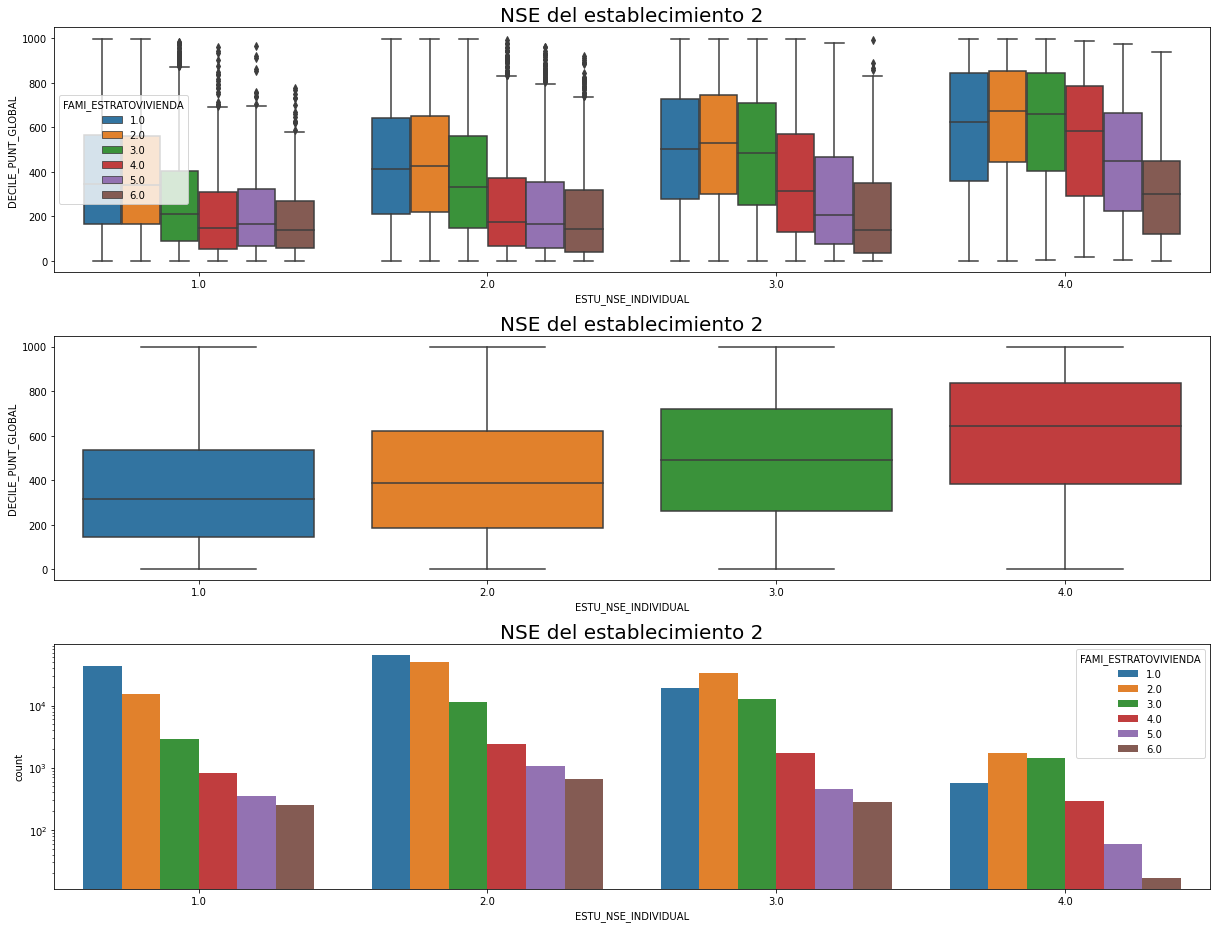

In [13]:
fig, ax = plt.subplots(nrows=3)
ax_1 , ax_2, ax_3 = ax
fig.set_size_inches(17, 13)
sns.boxplot(x="ESTU_NSE_INDIVIDUAL",y="DECILE_PUNT_GLOBAL",hue="FAMI_ESTRATOVIVIENDA",data=df_nse,ax=ax_1).set_title("NSE del establecimiento {}".format(2), fontsize=20)
sns.boxplot(x="ESTU_NSE_INDIVIDUAL",y="DECILE_PUNT_GLOBAL",data=df_nse,ax=ax_2).set_title("NSE del establecimiento {}".format(2), fontsize=20)
sns.countplot(x="ESTU_NSE_INDIVIDUAL",hue="FAMI_ESTRATOVIVIENDA",data=df_nse,ax=ax_3).set_title("NSE del establecimiento {}".format(2), fontsize=20)
ax_3.set_yscale('log')
plt.tight_layout()

In [14]:
tukey_undistinguishable(df_nse, category='ESTU_NSE_INDIVIDUAL', value='DECILE_PUNT_GLOBAL', groupby='FAMI_ESTRATOVIVIENDA')
tukey_undistinguishable(df_nse, category='FAMI_ESTRATOVIVIENDA', value='DECILE_PUNT_GLOBAL', groupby='ESTU_NSE_INDIVIDUAL')

Comparing groups of category ESTU_NSE_INDIVIDUAL
All differences for FAMI_ESTRATOVIVIENDA==1.0 were significant
All differences for FAMI_ESTRATOVIVIENDA==2.0 were significant
All differences for FAMI_ESTRATOVIVIENDA==3.0 were significant
Filter: FAMI_ESTRATOVIVIENDA==4.0
   group1  group2       Diff     Lower      Upper   q-value   p-value
2     2.0     1.0  46.243175  9.322732  83.163617  4.553445  0.007105
Filter: FAMI_ESTRATOVIVIENDA==5.0
   group1  group2        Diff      Lower       Upper   q-value   p-value
0     3.0     1.0   73.027801  11.381400  134.674202  4.312060  0.012622
1     3.0     2.0   51.421388   2.027352  100.815424  3.789428  0.037620
2     3.0     4.0  130.450000  17.383954  243.516046  4.199680  0.016161
3     1.0     2.0   21.606414 -32.292668   75.505496  1.459169  0.706165
Filter: FAMI_ESTRATOVIVIENDA==6.0
   group1  group2       Diff       Lower       Upper   q-value   p-value
0     2.0     3.0  20.267368  -37.696863   78.231600  1.274105  0.779644
1     2.0

### NSE_ESTABLECIMIENTO = 3

In [15]:
df_nse = df_training[df_training["ESTU_NSE_ESTABLECIMIENTO"]==3.0]

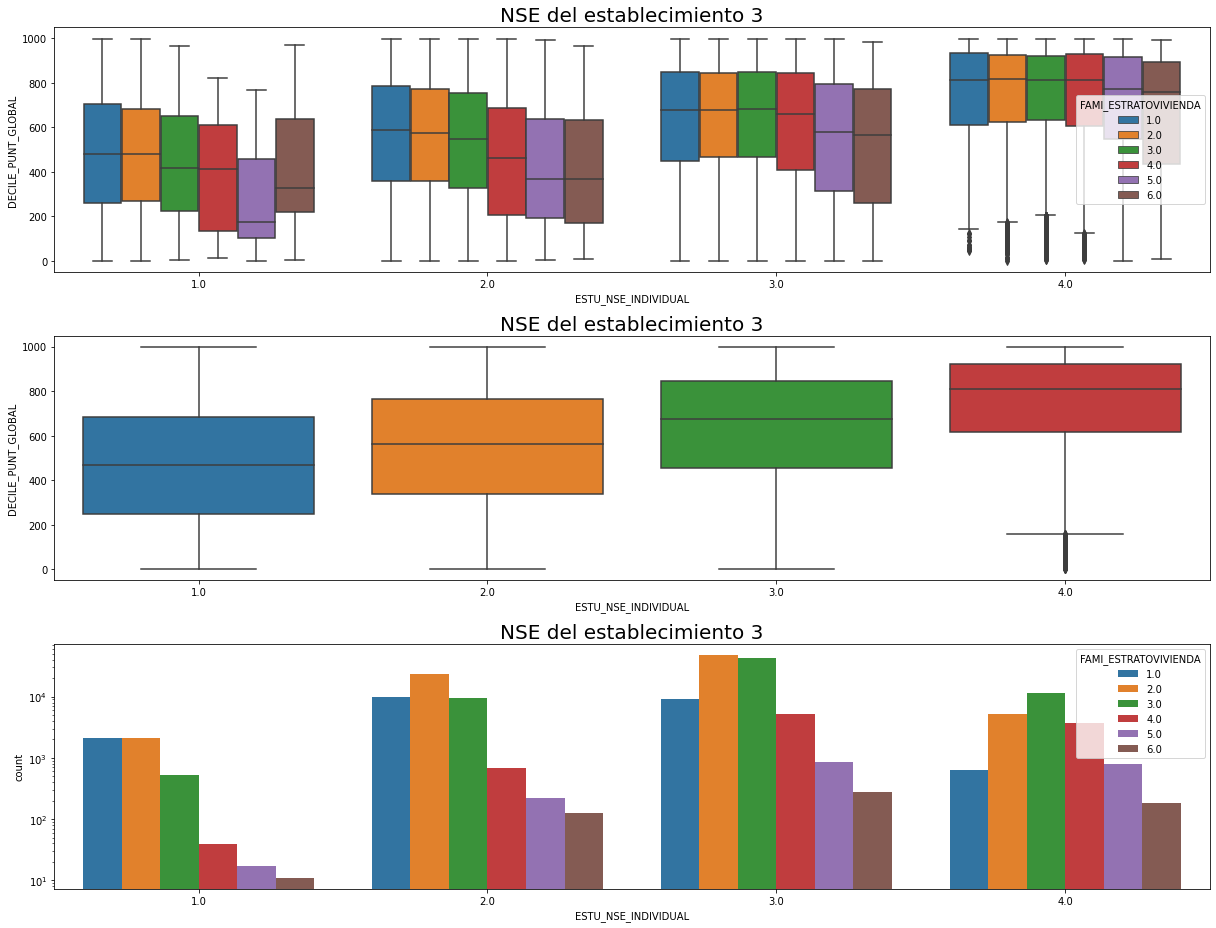

In [16]:
fig, ax = plt.subplots(nrows=3)
ax_1 , ax_2, ax_3 = ax
fig.set_size_inches(17, 13)
sns.boxplot(x="ESTU_NSE_INDIVIDUAL",y="DECILE_PUNT_GLOBAL",hue="FAMI_ESTRATOVIVIENDA",data=df_nse,ax=ax_1).set_title("NSE del establecimiento {}".format(3),fontsize=20)
sns.boxplot(x="ESTU_NSE_INDIVIDUAL",y="DECILE_PUNT_GLOBAL",data=df_nse,ax=ax_2).set_title("NSE del establecimiento {}".format(3),fontsize=20)
sns.countplot(x="ESTU_NSE_INDIVIDUAL",hue="FAMI_ESTRATOVIVIENDA",data=df_nse,ax=ax_3).set_title("NSE del establecimiento {}".format(3),fontsize=20)
ax_3.set_yscale('log')
plt.tight_layout()

In [17]:
tukey_undistinguishable(df_nse, category='ESTU_NSE_INDIVIDUAL', value='DECILE_PUNT_GLOBAL', groupby='FAMI_ESTRATOVIVIENDA')
tukey_undistinguishable(df_nse, category='FAMI_ESTRATOVIVIENDA', value='DECILE_PUNT_GLOBAL', groupby='ESTU_NSE_INDIVIDUAL')

Comparing groups of category ESTU_NSE_INDIVIDUAL
All differences for FAMI_ESTRATOVIVIENDA==1.0 were significant
All differences for FAMI_ESTRATOVIVIENDA==2.0 were significant
All differences for FAMI_ESTRATOVIVIENDA==3.0 were significant
Filter: FAMI_ESTRATOVIVIENDA==4.0
   group1  group2        Diff     Lower       Upper   q-value   p-value
5     2.0     1.0  149.028133 -3.403234  301.459501  3.553124  0.058152
Filter: FAMI_ESTRATOVIVIENDA==5.0
   group1  group2        Diff       Lower       Upper   q-value   p-value
4     3.0     1.0  219.187760    5.150207  433.225313  3.726865  0.042385
5     2.0     1.0   60.294175 -161.348137  281.936487  0.990011  0.892268
Filter: FAMI_ESTRATOVIVIENDA==6.0
   group1  group2        Diff       Lower       Upper   q-value   p-value
1     3.0     2.0  103.062223   -9.774634  215.899080  3.336742  0.087386
2     3.0     1.0  105.160584 -178.902979  389.224146  1.352420  0.748758
4     4.0     1.0  280.644860   -5.347943  566.637662  3.584892  0.05667

### NSE_ESTABLECIMIENTO = 4

In [18]:
df_nse = df_training[df_training["ESTU_NSE_ESTABLECIMIENTO"]==4.0]

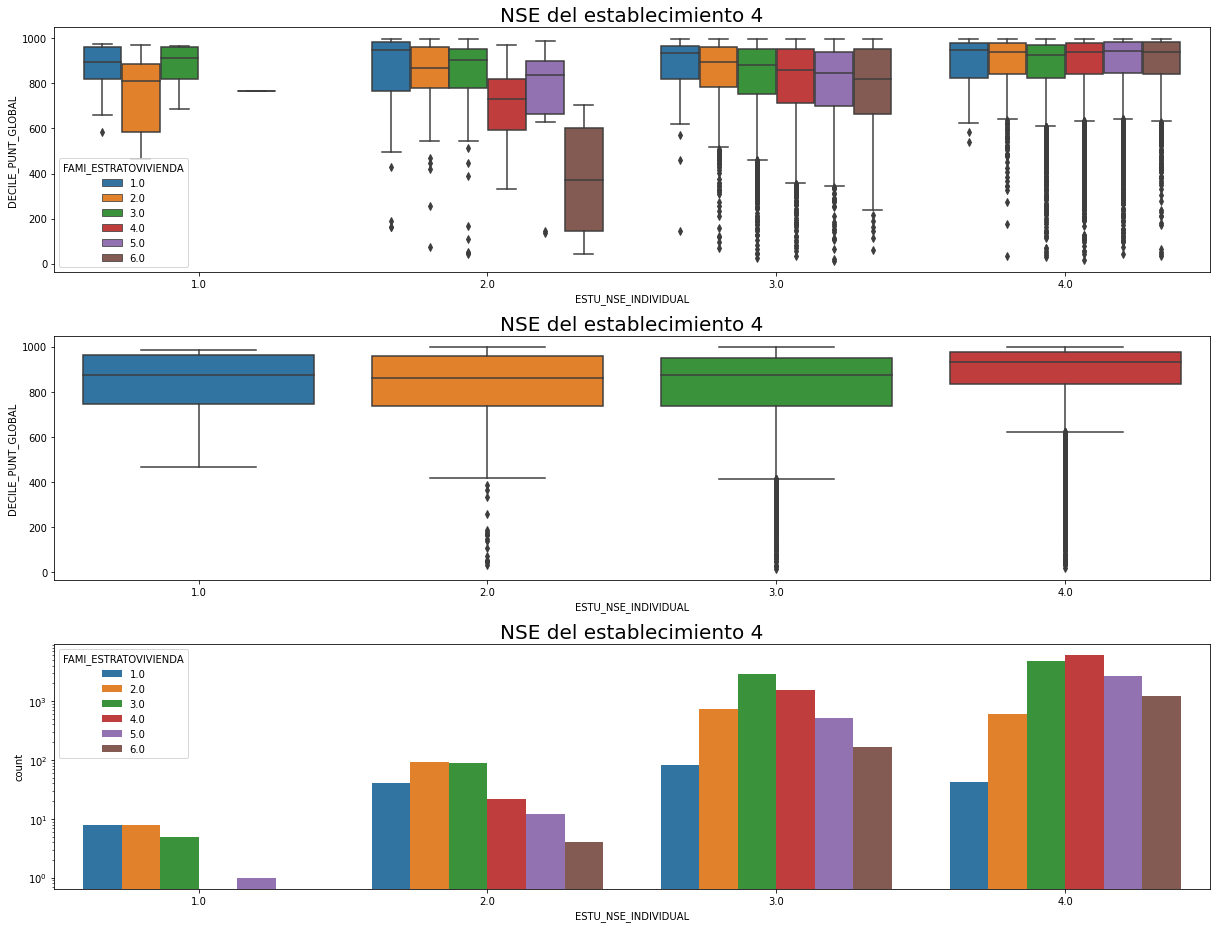

In [19]:
fig, ax = plt.subplots(nrows=3)
ax_1 , ax_2, ax_3 = ax
fig.set_size_inches(17, 13)
sns.boxplot(x="ESTU_NSE_INDIVIDUAL",y="DECILE_PUNT_GLOBAL",hue="FAMI_ESTRATOVIVIENDA",data=df_nse,ax=ax_1).set_title("NSE del establecimiento {}".format(4),fontsize=20)
sns.boxplot(x="ESTU_NSE_INDIVIDUAL",y="DECILE_PUNT_GLOBAL",data=df_nse,ax=ax_2).set_title("NSE del establecimiento {}".format(4),fontsize=20)
sns.countplot(x="ESTU_NSE_INDIVIDUAL",hue="FAMI_ESTRATOVIVIENDA",data=df_nse,ax=ax_3).set_title("NSE del establecimiento {}".format(4),fontsize=20)
ax_3.set_yscale('log')
plt.tight_layout()

In [20]:
tukey_undistinguishable(df_nse, category='ESTU_NSE_INDIVIDUAL', value='DECILE_PUNT_GLOBAL', groupby='FAMI_ESTRATOVIVIENDA')
tukey_undistinguishable(df_nse, category='FAMI_ESTRATOVIVIENDA', value='DECILE_PUNT_GLOBAL', groupby='ESTU_NSE_INDIVIDUAL')

Comparing groups of category ESTU_NSE_INDIVIDUAL
Filter: FAMI_ESTRATOVIVIENDA==1.0
   group1  group2       Diff       Lower       Upper   q-value   p-value
0     2.0     3.0  40.379447  -49.504961  130.263854  1.657028  0.629049
1     2.0     4.0  53.464674  -45.487367  152.416715  1.992948  0.496287
2     2.0     1.0  12.152174 -153.784269  178.088617  0.270126  0.900000
3     3.0     4.0  13.085227  -67.394336   93.564791  0.599721  0.900000
4     3.0     1.0  28.227273 -127.401634  183.856180  0.669010  0.900000
5     4.0     1.0  41.312500 -119.723696  202.348696  0.946263  0.900000
Filter: FAMI_ESTRATOVIVIENDA==2.0
   group1  group2        Diff       Lower       Upper   q-value   p-value
1     4.0     2.0   36.156125  -19.306123   91.618374  2.372931  0.336186
2     4.0     1.0  109.748718 -111.631349  331.128785  1.804520  0.569171
3     3.0     2.0    7.918632  -47.046926   62.884190  0.524397  0.900000
4     3.0     1.0   65.673961 -155.582193  286.930114  1.080435  0.856401
5 

## Puntajes fijando NSE_INDIVIDUAL

Dentro de cada NSE se ve que la tendencia es a menor estrato mayor puntaje

### NSE_INDIVIDUAL = 1

In [22]:
df_nse = df_training[df_training["ESTU_NSE_INDIVIDUAL"]==1.0]

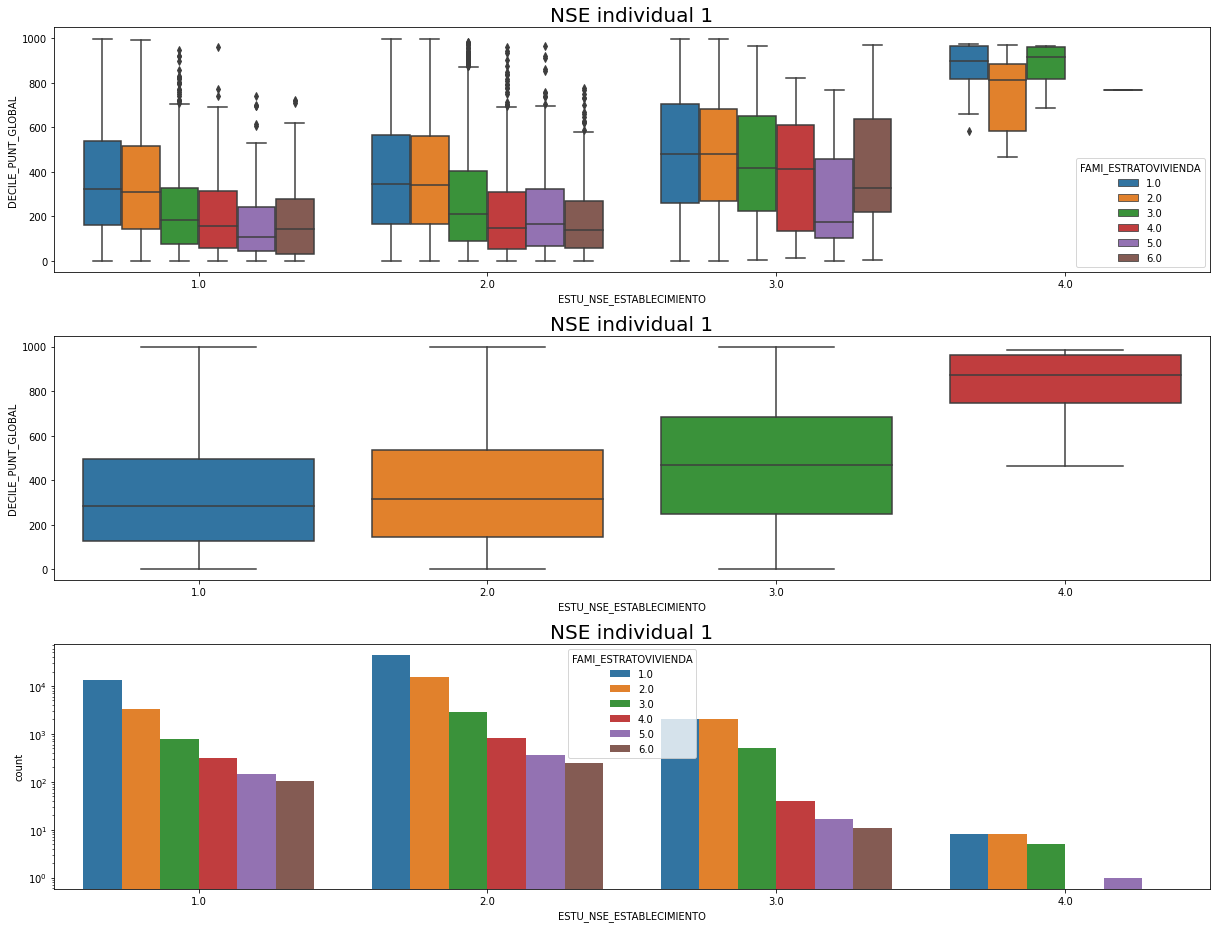

In [25]:
fig, ax = plt.subplots(nrows=3)
ax_1 , ax_2, ax_3 = ax
fig.set_size_inches(17, 13)
sns.boxplot(x="ESTU_NSE_ESTABLECIMIENTO",y="DECILE_PUNT_GLOBAL",hue="FAMI_ESTRATOVIVIENDA",data=df_nse,ax=ax_1).set_title("NSE individual {}".format(1),fontsize=20)
sns.boxplot(x="ESTU_NSE_ESTABLECIMIENTO",y="DECILE_PUNT_GLOBAL",data=df_nse,ax=ax_2).set_title("NSE individual {}".format(1),fontsize=20)
sns.countplot(x="ESTU_NSE_ESTABLECIMIENTO",hue="FAMI_ESTRATOVIVIENDA",data=df_nse,ax=ax_3).set_title("NSE individual {}".format(1),fontsize=20)
ax_3.set_yscale('log')
plt.tight_layout()

In [26]:
tukey_undistinguishable(df_nse, category='ESTU_NSE_ESTABLECIMIENTO', value='DECILE_PUNT_GLOBAL', groupby='FAMI_ESTRATOVIVIENDA')
tukey_undistinguishable(df_nse, category='FAMI_ESTRATOVIVIENDA', value='DECILE_PUNT_GLOBAL', groupby='ESTU_NSE_ESTABLECIMIENTO')

Comparing groups of category ESTU_NSE_ESTABLECIMIENTO
Filter: FAMI_ESTRATOVIVIENDA==1.0
   group1  group2        Diff      Lower       Upper   q-value   p-value
0     2.0     1.0    5.508317  -4.794107   15.810742  1.942615  0.514130
5     3.0     4.0  358.491420  94.296833  622.686008  4.930171  0.002764
Filter: FAMI_ESTRATOVIVIENDA==2.0
   group1  group2        Diff      Lower       Upper   q-value   p-value
0     2.0     1.0   22.941109   2.299004   43.583215  4.038463  0.022356
2     2.0     4.0  379.411289  11.340117  747.482462  3.745710  0.040405
4     1.0     4.0  402.352399  33.842050  770.862747  3.967461  0.025915
5     3.0     4.0  288.253389 -80.323236  656.830014  2.841858  0.184430
Filter: FAMI_ESTRATOVIVIENDA==3.0
   group1  group2       Diff     Lower      Upper   q-value  p-value
1     2.0     1.0  37.264733 -4.546763  79.076229  3.241096  0.10026
Filter: FAMI_ESTRATOVIVIENDA==4.0
   group1  group2        Diff      Lower       Upper   q-value   p-value
0     1.0     2

### NSE_INDIVIDUAL = 2

In [27]:
df_nse = df_training[df_training["ESTU_NSE_INDIVIDUAL"]==2.0]

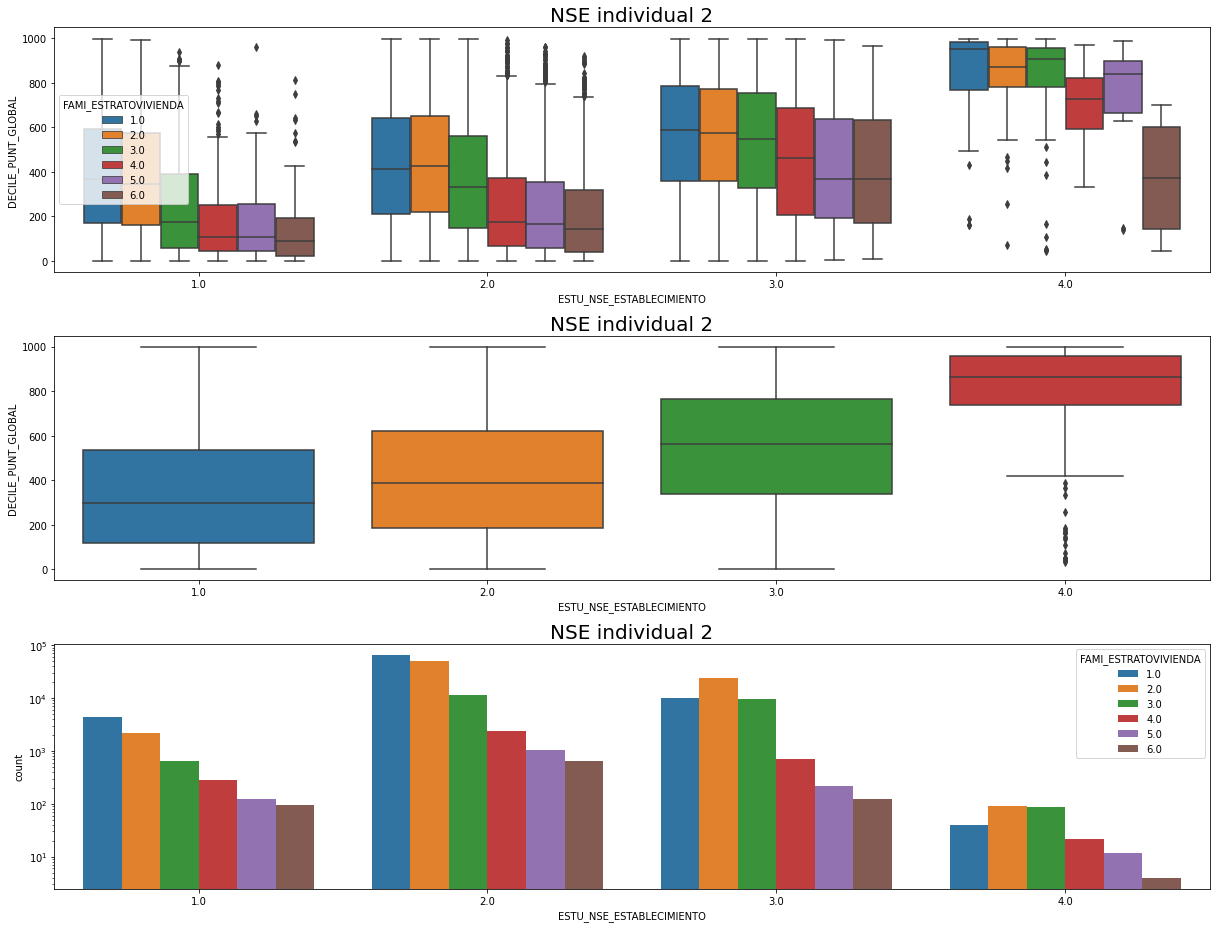

In [28]:
fig, ax = plt.subplots(nrows=3)
ax_1 , ax_2, ax_3 = ax
fig.set_size_inches(17, 13)
sns.boxplot(x="ESTU_NSE_ESTABLECIMIENTO",y="DECILE_PUNT_GLOBAL",hue="FAMI_ESTRATOVIVIENDA",data=df_nse,ax=ax_1).set_title("NSE individual {}".format(2),fontsize=20)
sns.boxplot(x="ESTU_NSE_ESTABLECIMIENTO",y="DECILE_PUNT_GLOBAL",data=df_nse,ax=ax_2).set_title("NSE individual {}".format(2),fontsize=20)
sns.countplot(x="ESTU_NSE_ESTABLECIMIENTO",hue="FAMI_ESTRATOVIVIENDA",data=df_nse,ax=ax_3).set_title("NSE individual {}".format(2),fontsize=20)
ax_3.set_yscale('log')
plt.tight_layout()

In [29]:
tukey_undistinguishable(df_nse, category='ESTU_NSE_ESTABLECIMIENTO', value='DECILE_PUNT_GLOBAL', groupby='FAMI_ESTRATOVIVIENDA')
tukey_undistinguishable(df_nse, category='FAMI_ESTRATOVIVIENDA', value='DECILE_PUNT_GLOBAL', groupby='ESTU_NSE_ESTABLECIMIENTO')

Comparing groups of category ESTU_NSE_ESTABLECIMIENTO
Filter: FAMI_ESTRATOVIVIENDA==1.0
   group1  group2       Diff     Lower     Upper   q-value  p-value
1     2.0     1.0  19.931074  2.564459  37.29769  4.169793  0.01686
All differences for FAMI_ESTRATOVIVIENDA==2.0 were significant
All differences for FAMI_ESTRATOVIVIENDA==3.0 were significant
Filter: FAMI_ESTRATOVIVIENDA==4.0
   group1  group2        Diff      Lower       Upper   q-value   p-value
0     2.0     1.0   43.143590 -36.696051  122.983230  1.965361  0.505247
5     3.0     4.0  236.583709  15.622931  457.544486  3.894165  0.030352
Filter: FAMI_ESTRATOVIVIENDA==5.0
   group1  group2        Diff      Lower       Upper   q-value   p-value
2     2.0     1.0   81.824537 -35.080618  198.729692  2.549975  0.272969
3     3.0     4.0  235.916936  23.478380  448.355493  4.045869  0.022619
Filter: FAMI_ESTRATOVIVIENDA==6.0
   group1  group2        Diff       Lower       Upper   q-value   p-value
0     2.0     1.0   55.129524  -85.4

### NSE_INDIVIDUAL = 3

In [30]:
df_nse = df_training[df_training["ESTU_NSE_INDIVIDUAL"]==3.0]

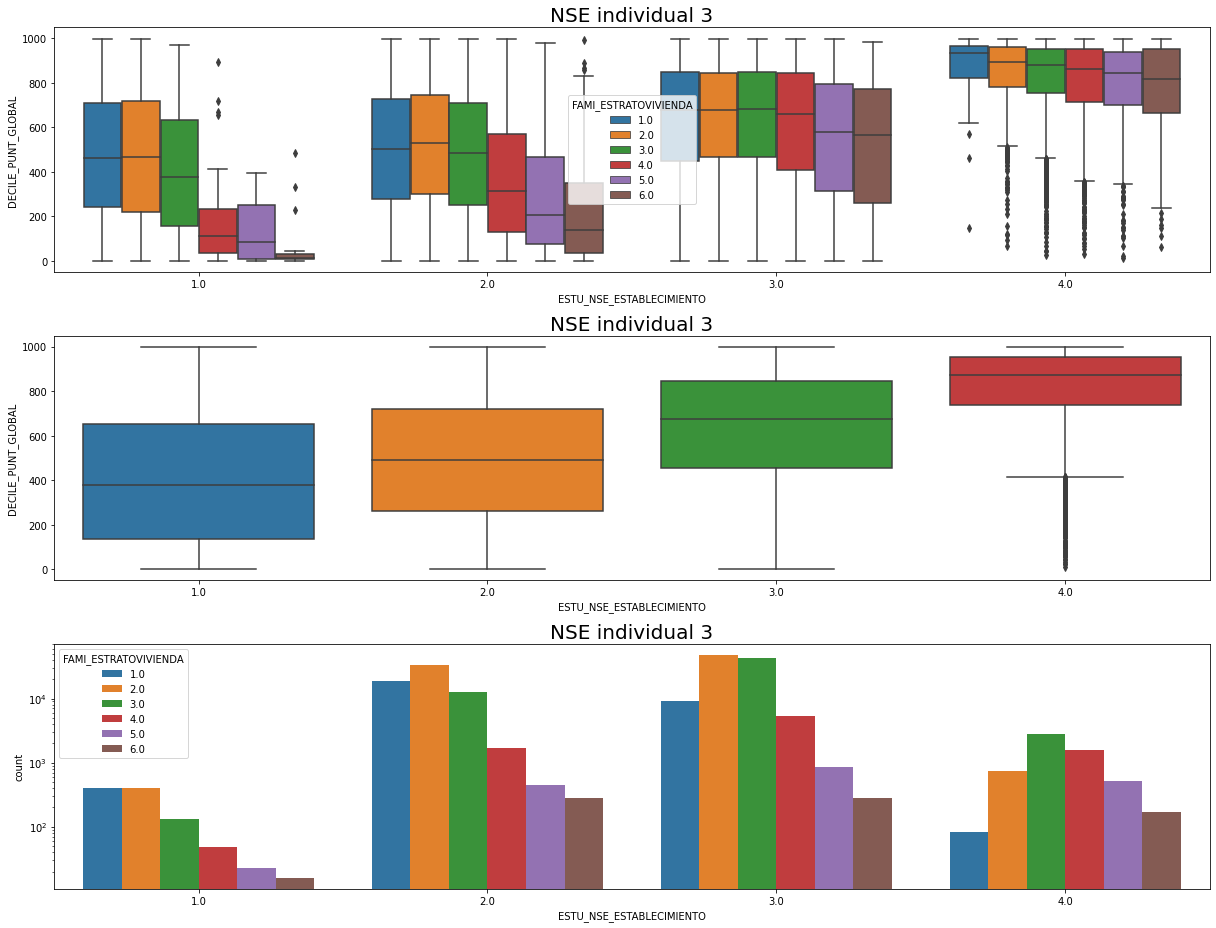

In [31]:
fig, ax = plt.subplots(nrows=3)
ax_1 , ax_2, ax_3 = ax
fig.set_size_inches(17, 13)
sns.boxplot(x="ESTU_NSE_ESTABLECIMIENTO",y="DECILE_PUNT_GLOBAL",hue="FAMI_ESTRATOVIVIENDA",data=df_nse,ax=ax_1).set_title("NSE individual {}".format(3),fontsize=20)
sns.boxplot(x="ESTU_NSE_ESTABLECIMIENTO",y="DECILE_PUNT_GLOBAL",data=df_nse,ax=ax_2).set_title("NSE individual {}".format(3),fontsize=20)
sns.countplot(x="ESTU_NSE_ESTABLECIMIENTO",hue="FAMI_ESTRATOVIVIENDA",data=df_nse,ax=ax_3).set_title("NSE individual {}".format(3),fontsize=20)
ax_3.set_yscale('log')
plt.tight_layout()

In [32]:
tukey_undistinguishable(df_nse, category='ESTU_NSE_ESTABLECIMIENTO', value='DECILE_PUNT_GLOBAL', groupby='FAMI_ESTRATOVIVIENDA')
tukey_undistinguishable(df_nse, category='FAMI_ESTRATOVIVIENDA', value='DECILE_PUNT_GLOBAL', groupby='ESTU_NSE_ESTABLECIMIENTO')

Comparing groups of category ESTU_NSE_ESTABLECIMIENTO
Filter: FAMI_ESTRATOVIVIENDA==1.0
   group1  group2       Diff      Lower      Upper   q-value  p-value
1     2.0     1.0  11.954841 -37.947392  61.857073  0.870462      0.9
Filter: FAMI_ESTRATOVIVIENDA==2.0
   group1  group2      Diff      Lower      Upper  q-value  p-value
2     2.0     1.0  9.219656 -39.501852  57.941165  0.68753      0.9
Filter: FAMI_ESTRATOVIVIENDA==3.0
   group1  group2       Diff      Lower       Upper   q-value   p-value
2     2.0     1.0  64.708289 -29.659701  159.076279  2.491373  0.292214
Filter: FAMI_ESTRATOVIVIENDA==4.0
   group1  group2        Diff     Lower       Upper   q-value   p-value
2     2.0     1.0  162.617942  4.624058  320.611826  3.740812  0.040849
Filter: FAMI_ESTRATOVIVIENDA==5.0
   group1  group2       Diff       Lower       Upper   q-value  p-value
2     2.0     1.0  135.29026 -111.683846  382.264365  1.993643  0.49373
Filter: FAMI_ESTRATOVIVIENDA==6.0
   group1  group2       Diff      

### NSE_INDIVIDUAL = 4

In [33]:
df_nse = df_training[df_training["ESTU_NSE_INDIVIDUAL"]==4.0]

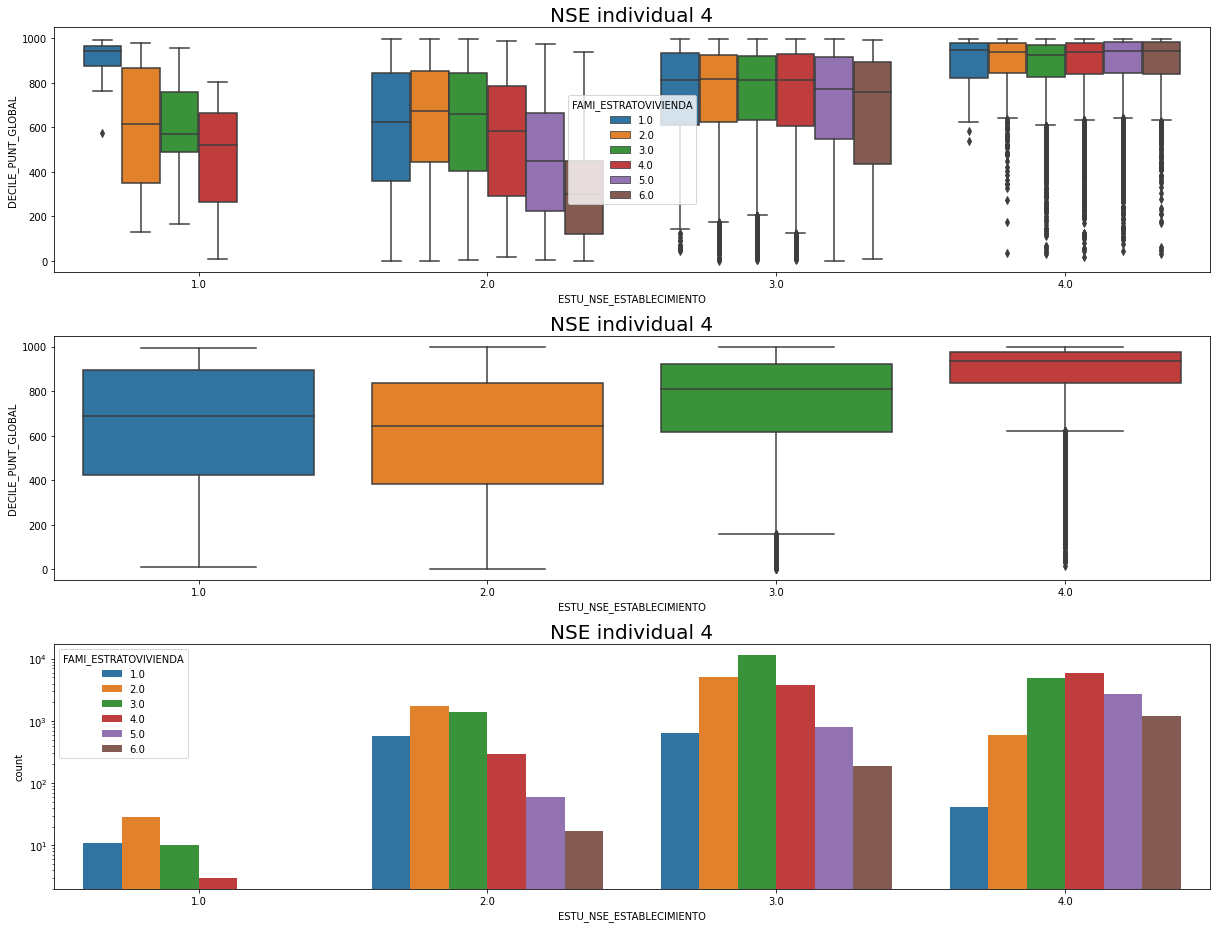

In [34]:
fig, ax = plt.subplots(nrows=3)
ax_1 , ax_2, ax_3 = ax
fig.set_size_inches(17, 13)
sns.boxplot(x="ESTU_NSE_ESTABLECIMIENTO",y="DECILE_PUNT_GLOBAL",hue="FAMI_ESTRATOVIVIENDA",data=df_nse,ax=ax_1).set_title("NSE individual {}".format(4),fontsize=20)
sns.boxplot(x="ESTU_NSE_ESTABLECIMIENTO",y="DECILE_PUNT_GLOBAL",data=df_nse,ax=ax_2).set_title("NSE individual {}".format(4),fontsize=20)
sns.countplot(x="ESTU_NSE_ESTABLECIMIENTO",hue="FAMI_ESTRATOVIVIENDA",data=df_nse,ax=ax_3).set_title("NSE individual {}".format(4),fontsize=20)
ax_3.set_yscale('log')
plt.tight_layout()

In [35]:
tukey_undistinguishable(df_nse, category='ESTU_NSE_ESTABLECIMIENTO', value='DECILE_PUNT_GLOBAL', groupby='FAMI_ESTRATOVIVIENDA')
tukey_undistinguishable(df_nse, category='FAMI_ESTRATOVIVIENDA', value='DECILE_PUNT_GLOBAL', groupby='ESTU_NSE_ESTABLECIMIENTO')

Comparing groups of category ESTU_NSE_ESTABLECIMIENTO
Filter: FAMI_ESTRATOVIVIENDA==1.0
   group1  group2        Diff       Lower       Upper   q-value   p-value
1     3.0     4.0  141.874381   24.726870  259.021892  4.408930  0.010166
2     3.0     1.0  130.284103  -84.706056  345.274263  2.206151  0.403558
4     2.0     1.0  304.176768   89.139290  519.214245  5.149608  0.001635
5     4.0     1.0   11.590278 -229.095915  252.276471  0.175309  0.900000
Filter: FAMI_ESTRATOVIVIENDA==2.0
   group1  group2        Diff      Lower       Upper   q-value   p-value
2     2.0     1.0   60.767762 -86.795014  208.330539  1.496706  0.691138
4     4.0     1.0  174.215385  24.807851  323.622918  4.237932  0.014579
5     3.0     1.0   49.874468 -97.094211  196.843148  1.233370  0.795647
Filter: FAMI_ESTRATOVIVIENDA==3.0
   group1  group2        Diff       Lower       Upper   q-value  p-value
2     3.0     1.0  177.902207   10.062028  345.742386  3.851524   0.0328
4     2.0     1.0   28.160259 -140.4

## Puntaje vs estrato y NSE de establecimiento

In [37]:
df_nse = df_training

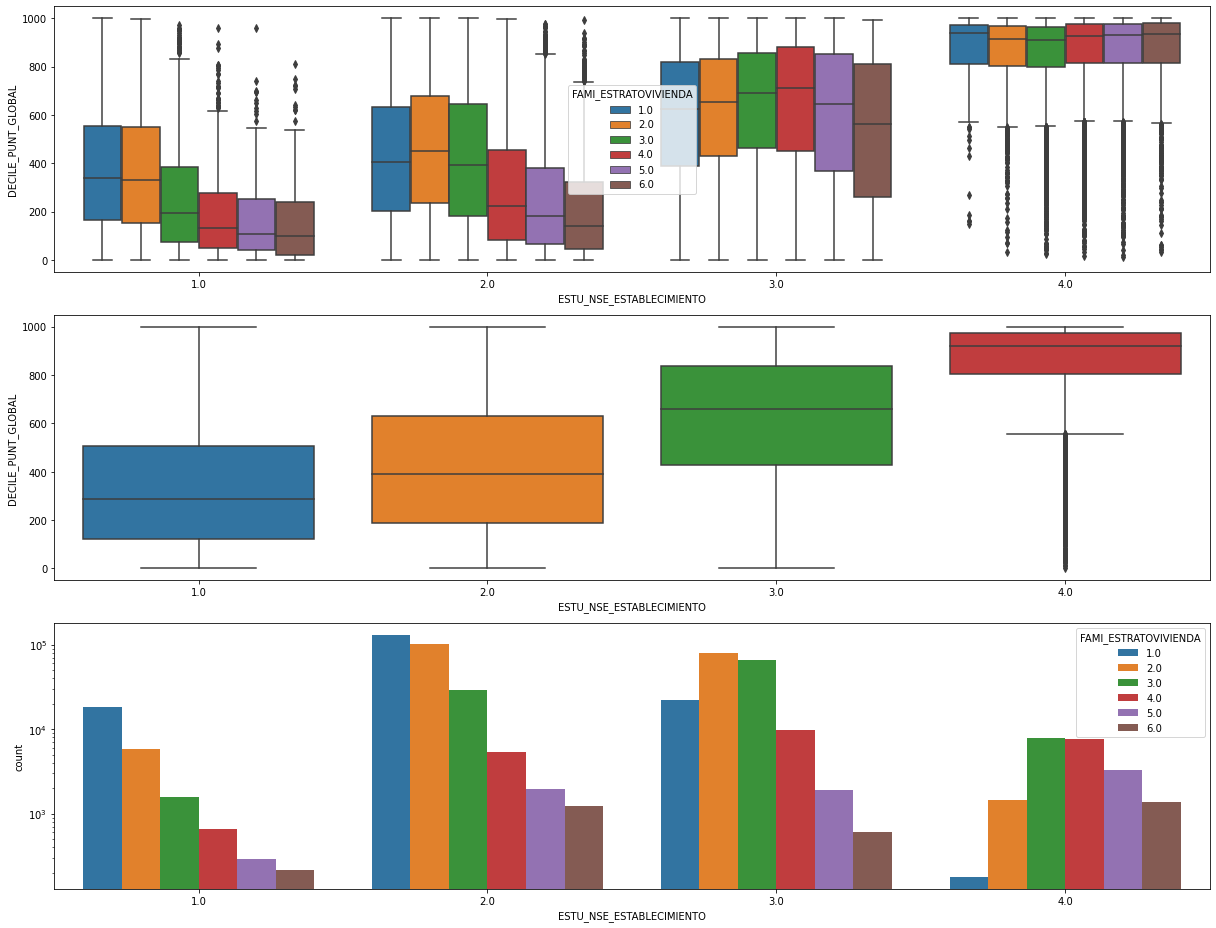

In [38]:
fig, ax = plt.subplots(nrows=3)
ax_1 , ax_2, ax_3 = ax
fig.set_size_inches(17, 13)
sns.boxplot(x="ESTU_NSE_ESTABLECIMIENTO",y="DECILE_PUNT_GLOBAL",hue="FAMI_ESTRATOVIVIENDA",data=df_nse,ax=ax_1)
sns.boxplot(x="ESTU_NSE_ESTABLECIMIENTO",y="DECILE_PUNT_GLOBAL",data=df_nse,ax=ax_2)
sns.countplot(x="ESTU_NSE_ESTABLECIMIENTO",hue="FAMI_ESTRATOVIVIENDA",data=df_nse,ax=ax_3)
ax_3.set_yscale('log')
plt.tight_layout()

In [39]:
tukey_undistinguishable(df_nse, category='ESTU_NSE_ESTABLECIMIENTO', value='DECILE_PUNT_GLOBAL', groupby='FAMI_ESTRATOVIVIENDA')
tukey_undistinguishable(df_nse, category='FAMI_ESTRATOVIVIENDA', value='DECILE_PUNT_GLOBAL', groupby='ESTU_NSE_ESTABLECIMIENTO')

Comparing groups of category ESTU_NSE_ESTABLECIMIENTO
All differences for FAMI_ESTRATOVIVIENDA==1.0 were significant
All differences for FAMI_ESTRATOVIVIENDA==2.0 were significant
All differences for FAMI_ESTRATOVIVIENDA==3.0 were significant
All differences for FAMI_ESTRATOVIVIENDA==4.0 were significant
Filter: FAMI_ESTRATOVIVIENDA==5.0
   group1  group2       Diff      Lower       Upper   q-value  p-value
4     2.0     1.0  73.492222  12.104587  134.879858  4.351244  0.01132
Filter: FAMI_ESTRATOVIVIENDA==6.0
   group1  group2       Diff      Lower       Upper  q-value   p-value
0     1.0     2.0  57.734258 -13.582743  129.051259  2.94381  0.159576
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Comparing groups of category FAMI_ESTRATOVIVIENDA
Filter: ESTU_NSE_ESTABLECIMIENTO==1.0
    group1  group2        Diff       Lower       Upper   q-value   p-value
2      6.0     4.0   60.708087  -45.124485  166.540659  2.312212  0.564688
3      6.0     3.0  104.731707    8.795477  200.667938

## Puntaje vs estrato fijando NSE_ESTABLECIMIENTO

Dentro de cada estrato se ve que la tendencia es a mayor NSE mayor Puntaje

### NSE_ESTABLECIMIENTO = 1

In [40]:
df_nse = df_training[df_training["ESTU_NSE_ESTABLECIMIENTO"]==1.0]

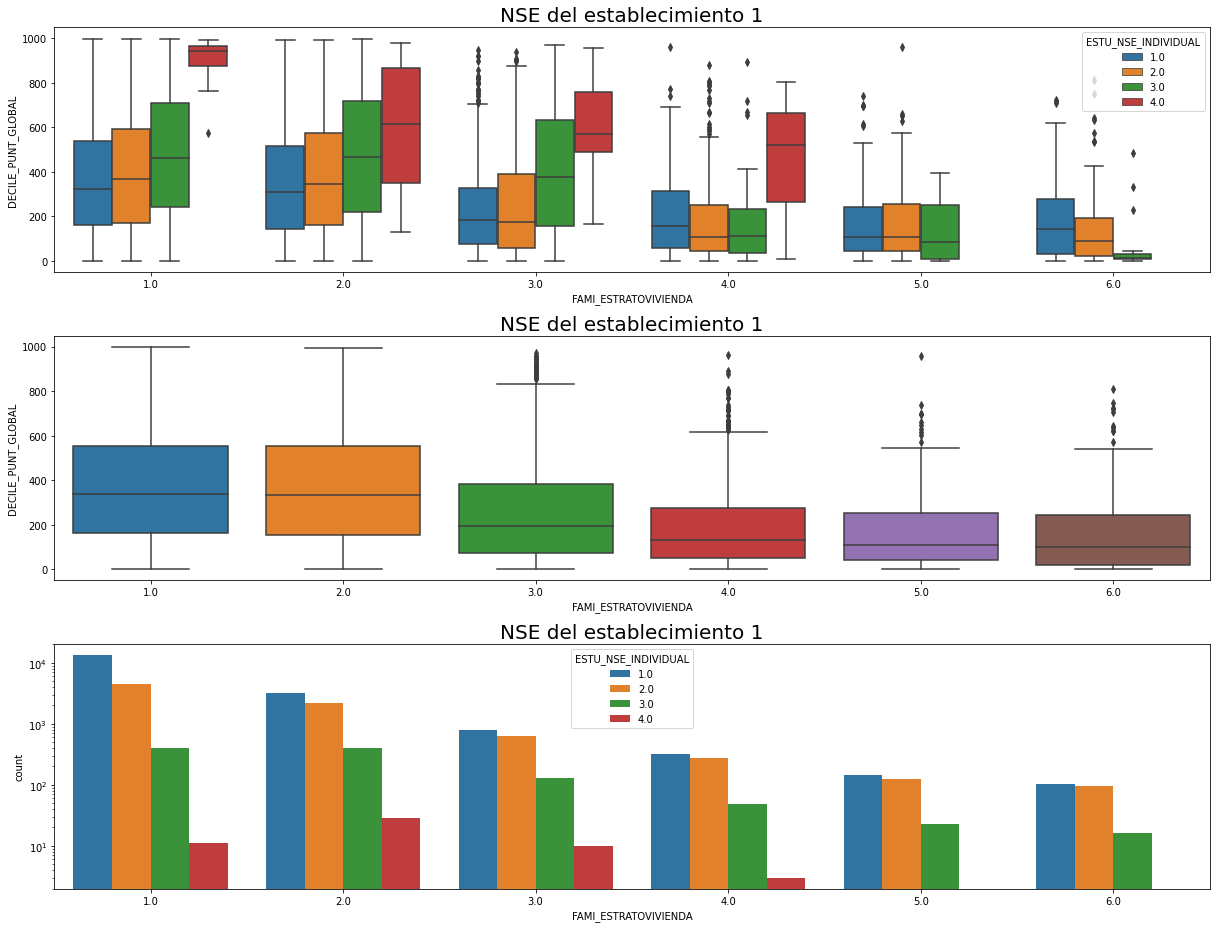

In [41]:
fig, ax = plt.subplots(nrows=3)
ax_1 , ax_2, ax_3 = ax
fig.set_size_inches(17, 13)
sns.boxplot(x="FAMI_ESTRATOVIVIENDA",y="DECILE_PUNT_GLOBAL",hue="ESTU_NSE_INDIVIDUAL",data=df_nse,ax=ax_1).set_title("NSE del establecimiento {}".format(1),fontsize=20)
sns.boxplot(x="FAMI_ESTRATOVIVIENDA",y="DECILE_PUNT_GLOBAL",data=df_nse,ax=ax_2).set_title("NSE del establecimiento {}".format(1),fontsize=20)
sns.countplot(x="FAMI_ESTRATOVIVIENDA",hue="ESTU_NSE_INDIVIDUAL",data=df_nse,ax=ax_3).set_title("NSE del establecimiento {}".format(1),fontsize=20)
ax_3.set_yscale('log')
plt.tight_layout()

### NSE_ESTABLECIMIENTO = 2

In [42]:
df_nse = df_training[df_training["ESTU_NSE_ESTABLECIMIENTO"]==2.0]

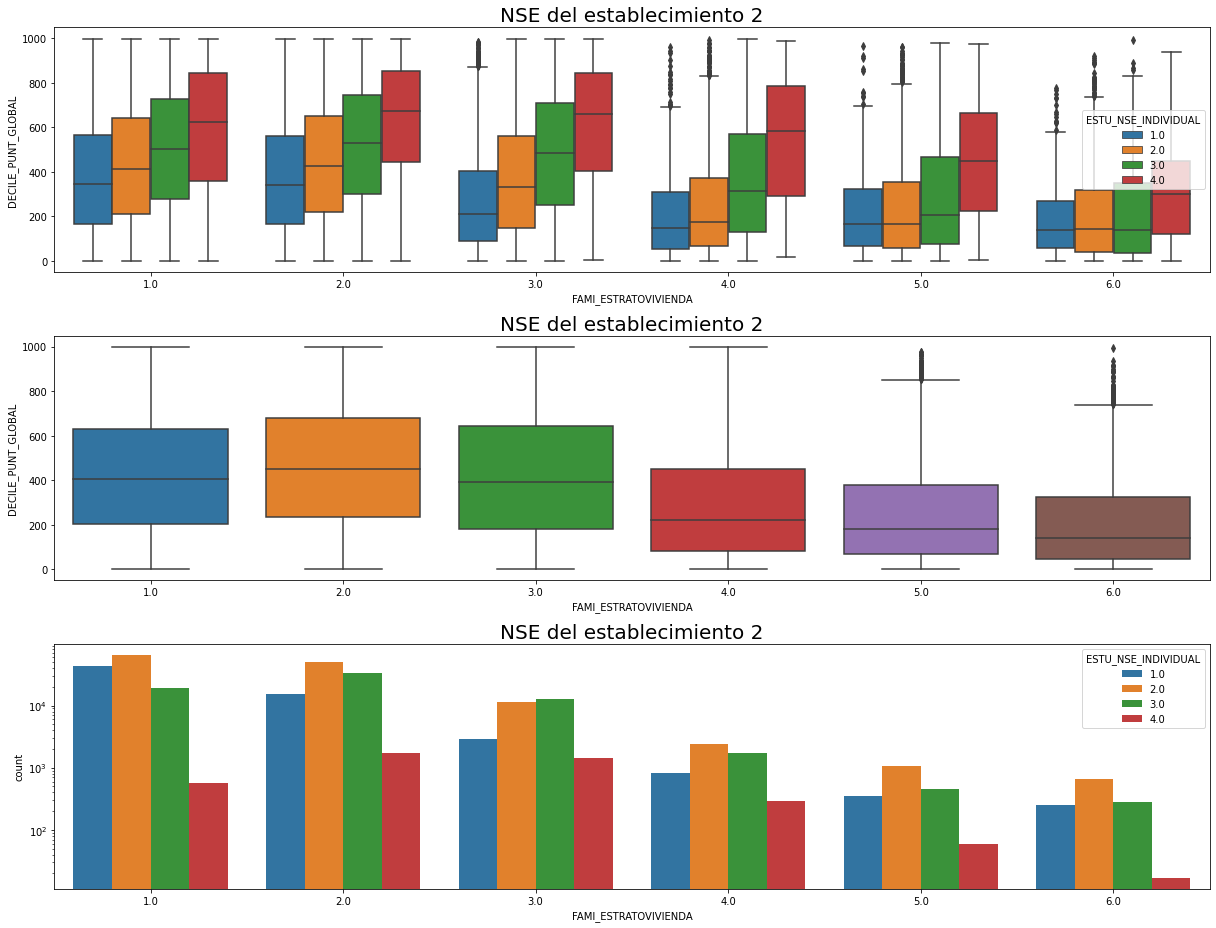

In [43]:
fig, ax = plt.subplots(nrows=3)
ax_1 , ax_2, ax_3 = ax
fig.set_size_inches(17, 13)
sns.boxplot(x="FAMI_ESTRATOVIVIENDA",y="DECILE_PUNT_GLOBAL",hue="ESTU_NSE_INDIVIDUAL",data=df_nse,ax=ax_1).set_title("NSE del establecimiento {}".format(2),fontsize=20)
sns.boxplot(x="FAMI_ESTRATOVIVIENDA",y="DECILE_PUNT_GLOBAL",data=df_nse,ax=ax_2).set_title("NSE del establecimiento {}".format(2),fontsize=20)
sns.countplot(x="FAMI_ESTRATOVIVIENDA",hue="ESTU_NSE_INDIVIDUAL",data=df_nse,ax=ax_3).set_title("NSE del establecimiento {}".format(2),fontsize=20)
ax_3.set_yscale('log')
plt.tight_layout()

### NSE_ESTABLECIMIENTO = 3

In [44]:
df_nse = df_training[df_training["ESTU_NSE_ESTABLECIMIENTO"]==3.0]

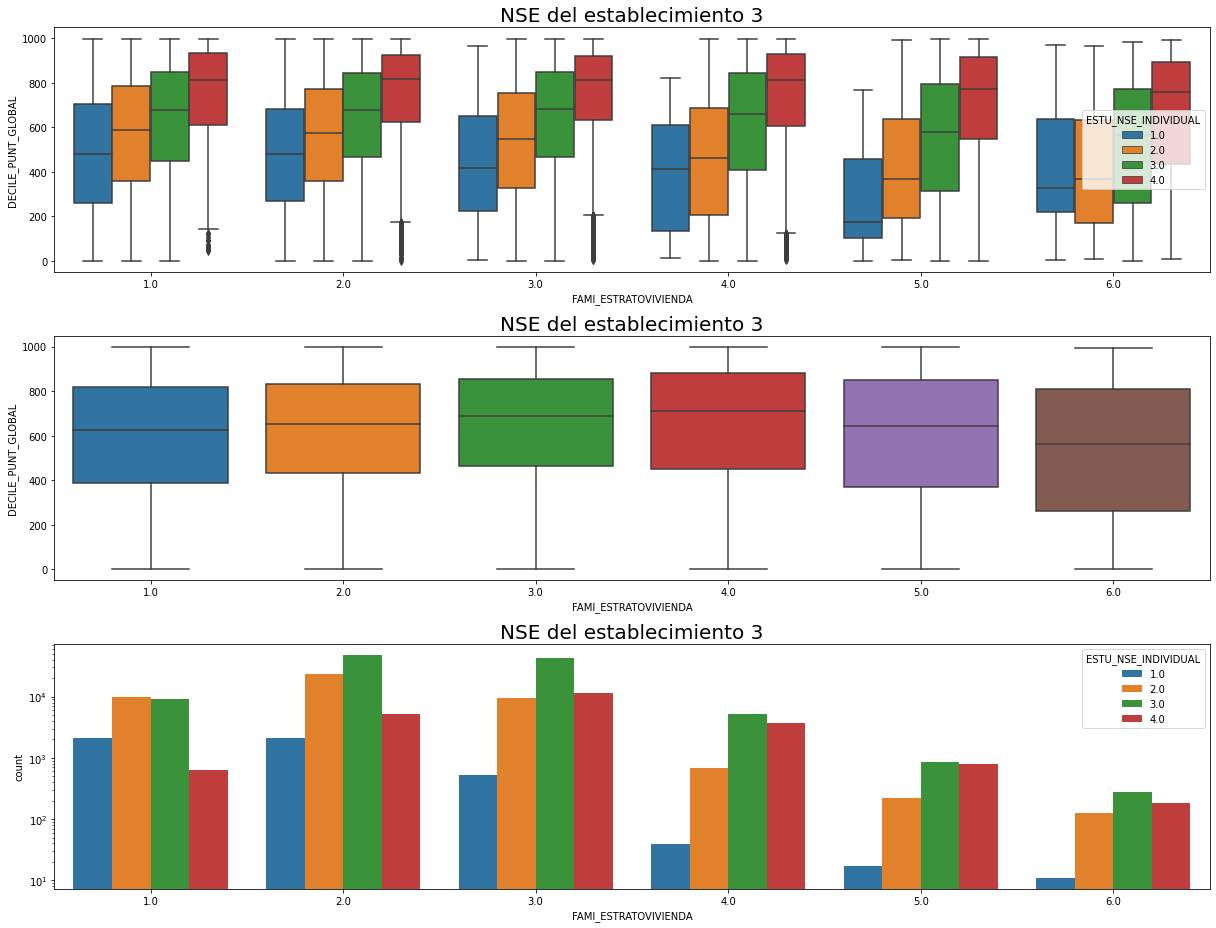

In [45]:
fig, ax = plt.subplots(nrows=3)
ax_1 , ax_2, ax_3 = ax
fig.set_size_inches(17, 13)
sns.boxplot(x="FAMI_ESTRATOVIVIENDA",y="DECILE_PUNT_GLOBAL",hue="ESTU_NSE_INDIVIDUAL",data=df_nse,ax=ax_1).set_title("NSE del establecimiento {}".format(3),fontsize=20)
sns.boxplot(x="FAMI_ESTRATOVIVIENDA",y="DECILE_PUNT_GLOBAL",data=df_nse,ax=ax_2).set_title("NSE del establecimiento {}".format(3),fontsize=20)
sns.countplot(x="FAMI_ESTRATOVIVIENDA",hue="ESTU_NSE_INDIVIDUAL",data=df_nse,ax=ax_3).set_title("NSE del establecimiento {}".format(3),fontsize=20)
ax_3.set_yscale('log')
plt.tight_layout()

### NSE_ESTABLECIMIENTO = 4

In [46]:
df_nse = df_training[df_training["ESTU_NSE_ESTABLECIMIENTO"]==4.0]

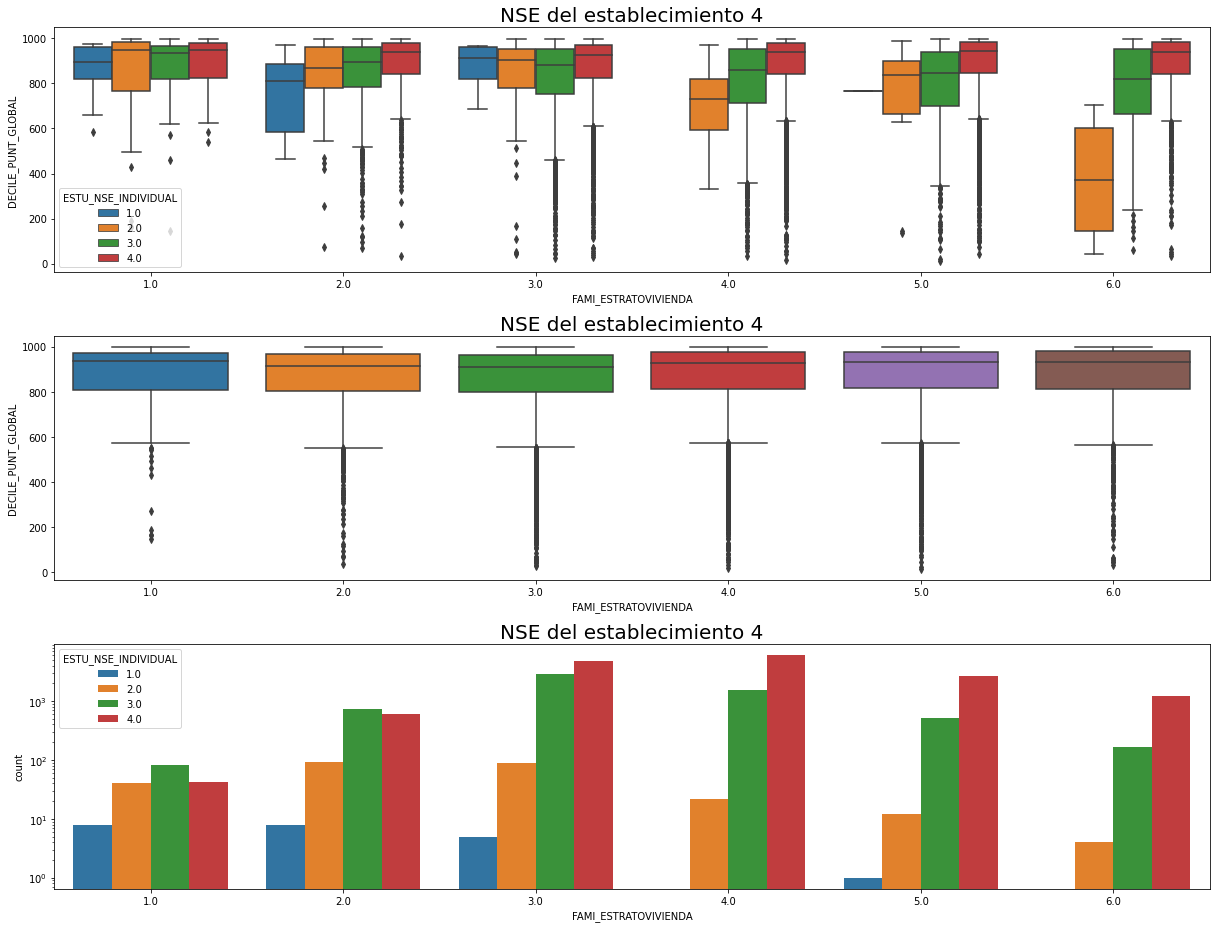

In [47]:
fig, ax = plt.subplots(nrows=3)
ax_1 , ax_2, ax_3 = ax
fig.set_size_inches(17, 13)
sns.boxplot(x="FAMI_ESTRATOVIVIENDA",y="DECILE_PUNT_GLOBAL",hue="ESTU_NSE_INDIVIDUAL",data=df_nse,ax=ax_1).set_title("NSE del establecimiento {}".format(4),fontsize=20)
sns.boxplot(x="FAMI_ESTRATOVIVIENDA",y="DECILE_PUNT_GLOBAL",data=df_nse,ax=ax_2).set_title("NSE del establecimiento {}".format(4),fontsize=20)
sns.countplot(x="FAMI_ESTRATOVIVIENDA",hue="ESTU_NSE_INDIVIDUAL",data=df_nse,ax=ax_3).set_title("NSE del establecimiento {}".format(4),fontsize=20)
ax_3.set_yscale('log')
plt.tight_layout()

## Puntaje vs estrato de la vivienda fijando NSE_INDIVIDUAL

Para cada estrato se observa la tendencia de a mayor NSE mayor puntaje

### NSE_INDIVUDAL =1

In [48]:
df_nse = df_training[df_training["ESTU_NSE_INDIVIDUAL"]==1.0]

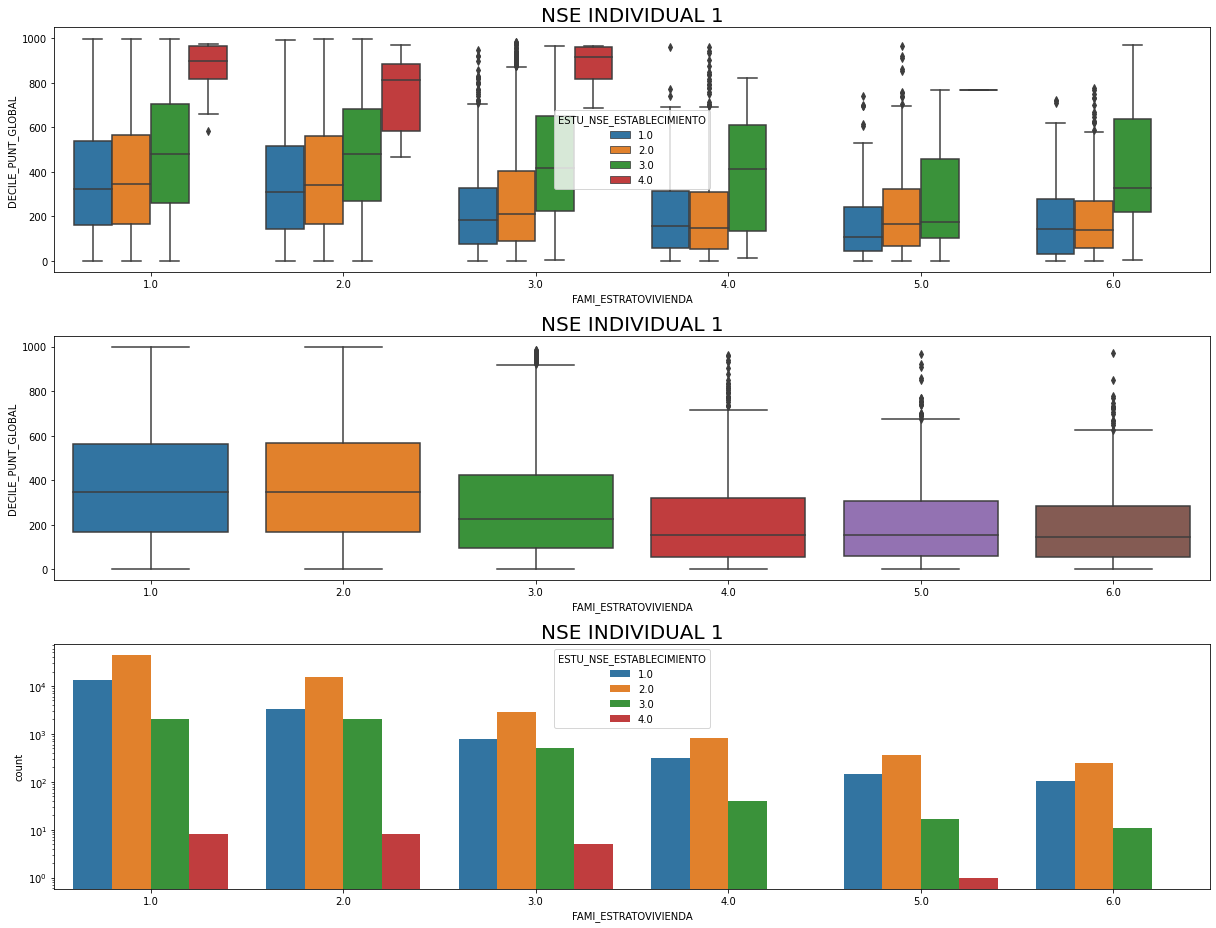

In [49]:
fig, ax = plt.subplots(nrows=3)
ax_1 , ax_2, ax_3 = ax
fig.set_size_inches(17, 13)
sns.boxplot(x="FAMI_ESTRATOVIVIENDA",y="DECILE_PUNT_GLOBAL",hue="ESTU_NSE_ESTABLECIMIENTO",data=df_nse,ax=ax_1).set_title("NSE INDIVIDUAL {}".format(1),fontsize=20)
sns.boxplot(x="FAMI_ESTRATOVIVIENDA",y="DECILE_PUNT_GLOBAL",data=df_nse,ax=ax_2).set_title("NSE INDIVIDUAL {}".format(1),fontsize=20)
sns.countplot(x="FAMI_ESTRATOVIVIENDA",hue="ESTU_NSE_ESTABLECIMIENTO",data=df_nse,ax=ax_3).set_title("NSE INDIVIDUAL {}".format(1),fontsize=20)
ax_3.set_yscale('log')
plt.tight_layout()

### NSE_INDIVIDUAL = 2

In [50]:
df_nse = df_training[df_training["ESTU_NSE_INDIVIDUAL"]==2.0]

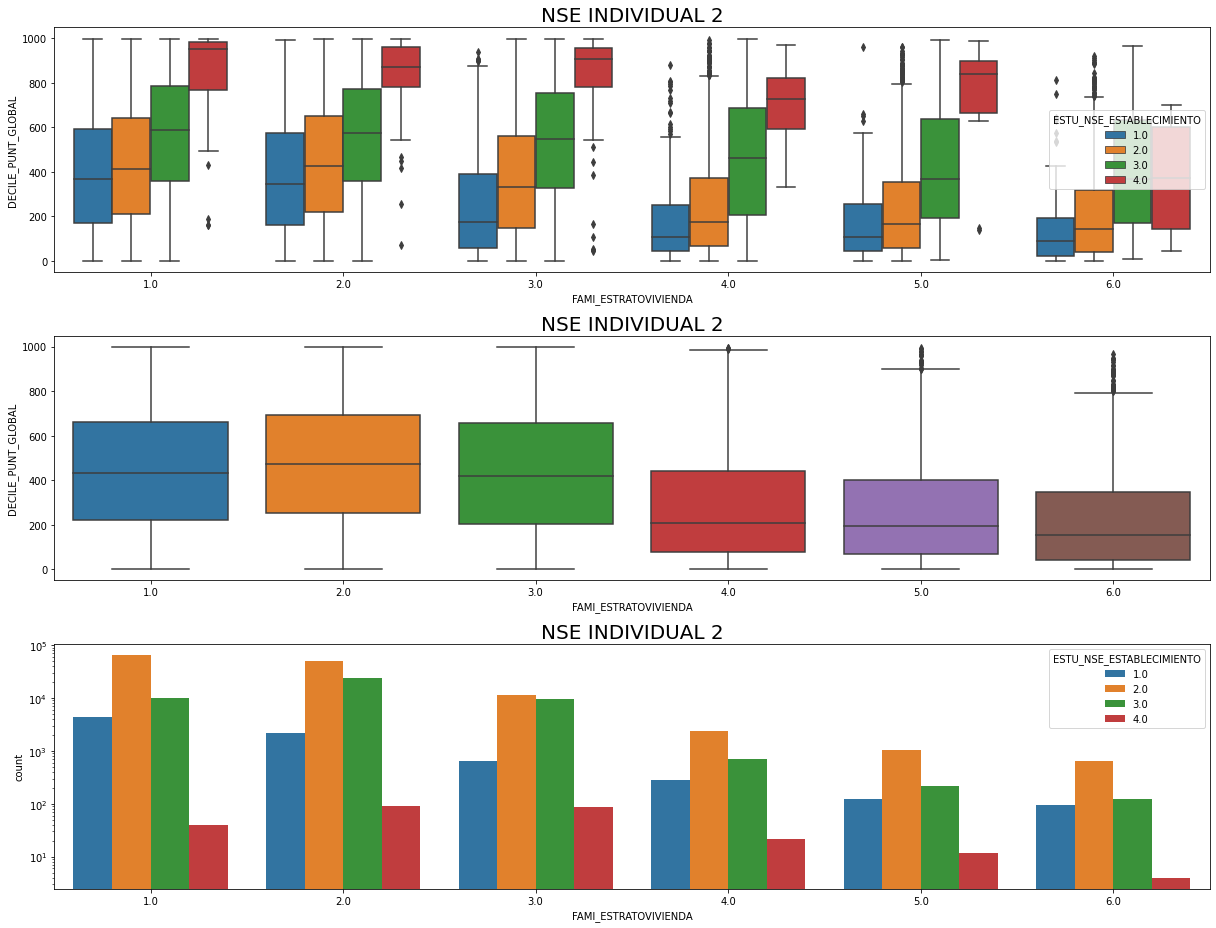

In [51]:
fig, ax = plt.subplots(nrows=3)
ax_1 , ax_2, ax_3 = ax
fig.set_size_inches(17, 13)
sns.boxplot(x="FAMI_ESTRATOVIVIENDA",y="DECILE_PUNT_GLOBAL",hue="ESTU_NSE_ESTABLECIMIENTO",data=df_nse,ax=ax_1).set_title("NSE INDIVIDUAL {}".format(2), fontsize=20)
sns.boxplot(x="FAMI_ESTRATOVIVIENDA",y="DECILE_PUNT_GLOBAL",data=df_nse,ax=ax_2).set_title("NSE INDIVIDUAL {}".format(2), fontsize=20)
sns.countplot(x="FAMI_ESTRATOVIVIENDA",hue="ESTU_NSE_ESTABLECIMIENTO",data=df_nse,ax=ax_3).set_title("NSE INDIVIDUAL {}".format(2), fontsize=20)
ax_3.set_yscale('log')
plt.tight_layout()

### NSE_INDIVIDUAL = 3

In [52]:
df_nse = df_training[df_training["ESTU_NSE_INDIVIDUAL"]==3.0]

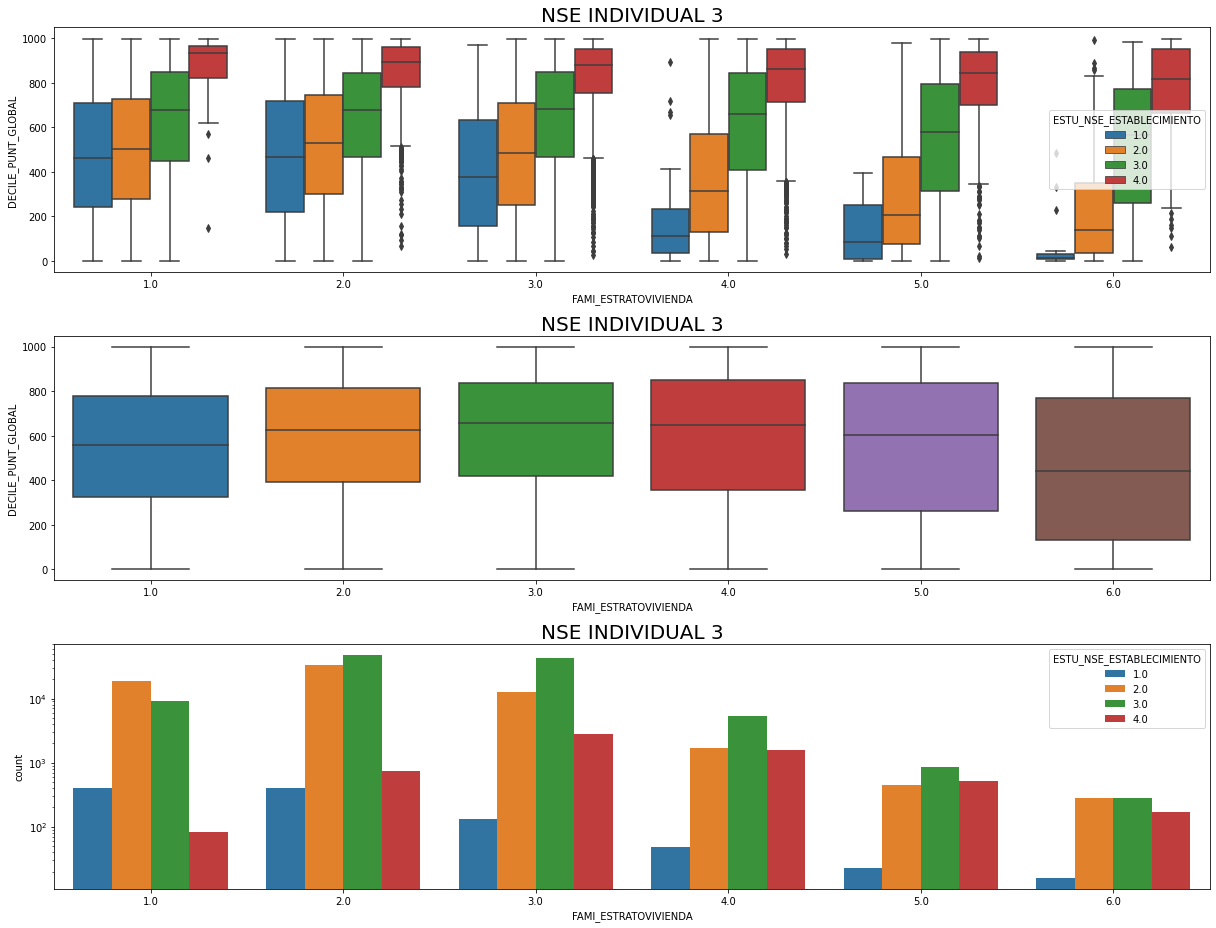

In [53]:
fig, ax = plt.subplots(nrows=3)
ax_1 , ax_2, ax_3 = ax
fig.set_size_inches(17, 13)
sns.boxplot(x="FAMI_ESTRATOVIVIENDA",y="DECILE_PUNT_GLOBAL",hue="ESTU_NSE_ESTABLECIMIENTO",data=df_nse,ax=ax_1).set_title("NSE INDIVIDUAL {}".format(3),fontsize=20)
sns.boxplot(x="FAMI_ESTRATOVIVIENDA",y="DECILE_PUNT_GLOBAL",data=df_nse,ax=ax_2).set_title("NSE INDIVIDUAL {}".format(3),fontsize=20)
sns.countplot(x="FAMI_ESTRATOVIVIENDA",hue="ESTU_NSE_ESTABLECIMIENTO",data=df_nse,ax=ax_3).set_title("NSE INDIVIDUAL {}".format(3),fontsize=20)
ax_3.set_yscale('log')
plt.tight_layout()

### NSE_INDIVIDUAL = 4

In [54]:
df_nse = df_training[df_training["ESTU_NSE_INDIVIDUAL"]==4.0]

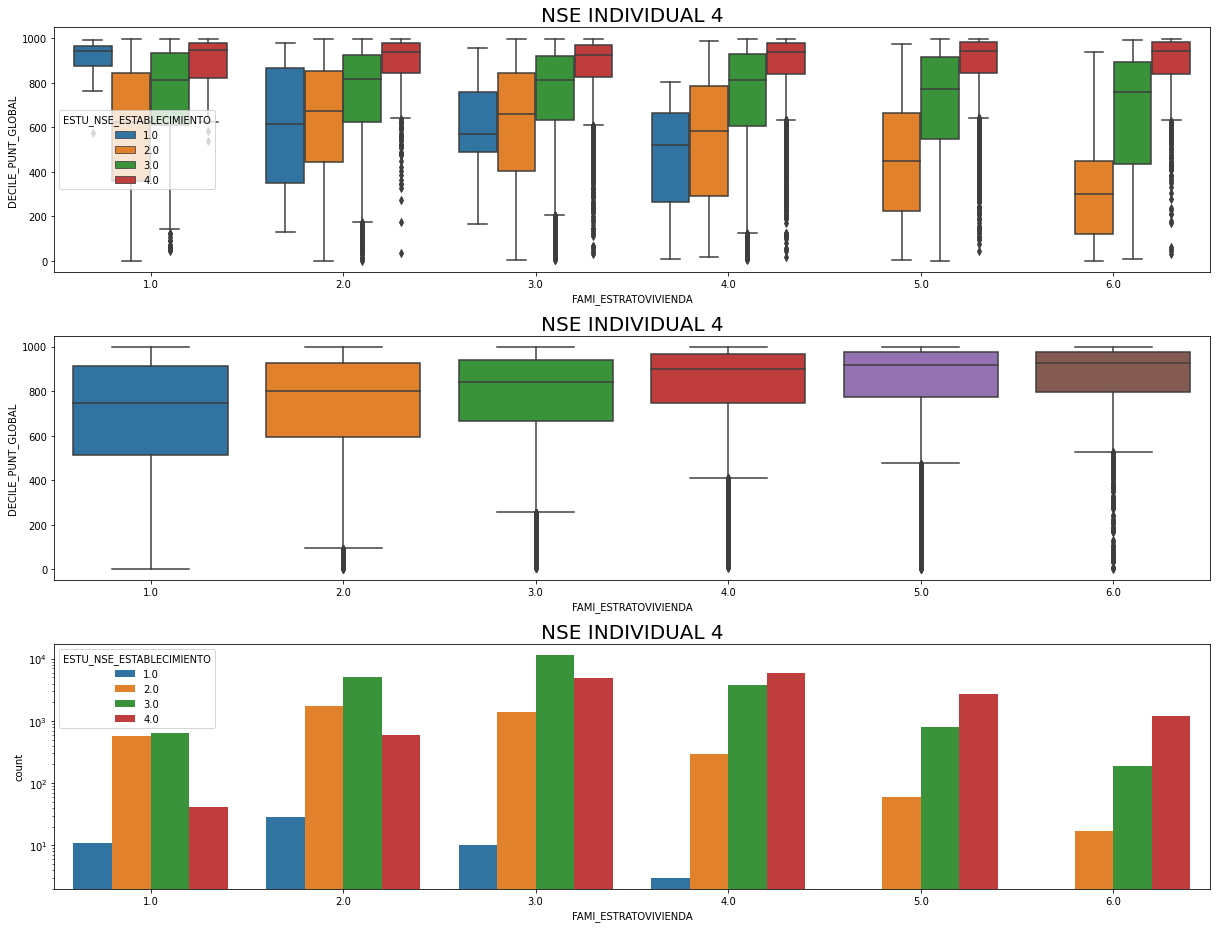

In [55]:
fig, ax = plt.subplots(nrows=3)
ax_1 , ax_2, ax_3 = ax
fig.set_size_inches(17, 13)
sns.boxplot(x="FAMI_ESTRATOVIVIENDA",y="DECILE_PUNT_GLOBAL",hue="ESTU_NSE_ESTABLECIMIENTO",data=df_nse,ax=ax_1).set_title("NSE INDIVIDUAL {}".format(4),fontsize=20)
sns.boxplot(x="FAMI_ESTRATOVIVIENDA",y="DECILE_PUNT_GLOBAL",data=df_nse,ax=ax_2).set_title("NSE INDIVIDUAL {}".format(4),fontsize=20)
sns.countplot(x="FAMI_ESTRATOVIVIENDA",hue="ESTU_NSE_ESTABLECIMIENTO",data=df_nse,ax=ax_3).set_title("NSE INDIVIDUAL {}".format(4),fontsize=20)
ax_3.set_yscale('log')
plt.tight_layout()